In [1]:
%load_ext autoreload
%autoreload 2
import os; import sys; sys.path.insert(0,'../')
import pandas as pd
import numpy as np
import tqdm
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import atomic.features as fs
import matplotlib.pyplot as plt
import pattern.vis as vis
import sklearn.mixture as mix
#import socceraction.atomic.labels as lab
import matplotsoccer as mps

In [2]:
## Configure file and folder names
datafolder = "../data/private"
spadl_h5 = os.path.join(datafolder,"spadl-statsbomb.h5")

In [3]:
games = pd.read_hdf(spadl_h5,"games")
games = games[(games.competition_name == "Premier League")
             & (games.season_name == "2018/2019")]
print("nb of games:", len(games))

actiontypes = pd.read_hdf(spadl_h5, "atomic_actiontypes")
bodyparts = pd.read_hdf(spadl_h5, "bodyparts")

nb of games: 380


In [4]:
with pd.HDFStore(spadl_h5) as spadlstore:
    actions = []
    for game in tqdm.tqdm(games.itertuples()):
        a = spadlstore[f"atomic_actions/game_{game.game_id}"]
        [a] = fs.play_left_to_right([a],game.home_team_id)
        a["is_home"] = a.team_id == game.home_team_id
        actions.append(a)
    actions = pd.concat(actions)
    actions = actions.merge(spadlstore["atomic_actiontypes"],how="left")
actions[:5]

380it [00:10, 37.87it/s]


,game_id,period_id,action_id,time_seconds,timestamp,team_id,player_id,x,y,dx,dy,type_id,bodypart_id,is_home,type_name
0,14562.0,1.0,0,1.0,00:00:01.344,58.0,9923.0,52.058824,34.430380,-10.588235,-0.000000,0,0,False,pass
1,14562.0,1.0,1,1.5,00:00:02.117,58.0,9917.0,41.470588,34.430380,-0.000000,-0.000000,23,0,False,receival
2,14562.0,1.0,2,2.0,00:00:02.117,58.0,9917.0,41.470588,34.430380,-0.000000,-0.000000,21,0,False,dribble
3,14562.0,1.0,3,2.0,00:00:02.969,58.0,9917.0,41.470588,34.430380,-15.882353,-14.632911,0,0,False,pass
4,14562.0,1.0,4,3.0,00:00:04.338,58.0,9924.0,25.588235,19.797468,-0.000000,-0.000000,23,0,False,receival


In [5]:
# Make a nice action subset
import pattern.action as pat

a = actions[200000:400000].fillna(0)
a = pat.simplify(a)
#a["type_name"] = a.type_name.mask(~a.is_home,a.type_name + "_opp")
a["x"] = a.x.mask(a.type_name=="goal",105)
a["y"] = a.y.mask(a.type_name=="goal",32.5)
a["dx"] = a.dx.mask(a.type_name=="shot",0)
a["dy"] = a.dy.mask(a.type_name=="shot",0)

In [6]:
#ac = a[a.type_name.isin(["cross","corner","throw_in","shot"])]
candidates = pat.candidates(a,["x","y","dx","dy"],30,True)
lns = {t : len(a[a.type_name==t]) for t in set(a.type_name)}

Training goal components:   0%|          | 0/30 [00:00<?, ?it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
Training goal components:  10%|█         | 3/30 [00:00<00:01, 18.20it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: Conv

Training goal components:  87%|████████▋ | 26/30 [00:02<00:00,  7.95it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (27). Possibly due to duplicate points in X.
  return_n_iter=True)
Training goal components:  90%|█████████ | 27/30 [00:02<00:00,  7.82it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (28). Possibly due to duplicate points in X.
  return_n_iter=True)
Training goal components:  93%|█████████▎| 28/30 [00:02<00:00,  7.69it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (29). Possibly due to duplicate points in X.
  return_n_iter=True)
Training goal componen

In [10]:
list((m.n_components,s) for t,m,s in candidates if t == "shot")

[(1, 7635.6047173206725),
 (2, 7784.442829168494),
 (3, 7854.114886137195),
 (4, 7867.201913074508),
 (5, 7970.0086529732625),
 (6, 7983.871165026274),
 (7, 7981.542625026545),
 (8, 7992.622436272616),
 (9, 7995.6520709099095),
 (10, 8007.160432653467),
 (11, 8008.262839474784),
 (12, 8026.219168948088),
 (13, 8030.574559244363),
 (14, 8037.713216894286),
 (15, 8036.9884414564485),
 (16, 8044.998981784355),
 (17, 8052.750875587806),
 (18, 8053.0160170934905),
 (19, 8066.517097762361),
 (20, 8061.999067701146),
 (21, 8068.335704264806),
 (22, 8084.012566061789),
 (23, 8069.6960869618215),
 (24, 8087.854775521302),
 (25, 8114.60985231162),
 (26, 8085.088381761607),
 (27, 8090.587897878686),
 (28, 8092.2522120846525),
 (29, 8101.661745403631),
 (30, 8097.989543983152)]

In [219]:
#import np.linalg
def covarnorm(gmm):
    covars = gmm.covariances_
    s = 0
    for i in range(len(covars)):
        s += np.linalg.norm(np.diag(covars[i]))
    return s/len(covars)

In [223]:
list((m.n_components,s) for t,m,s in normcandidates if t=="shot")

[(1, -95.61760178596637),
 (2, -76.62981276981364),
 (3, -60.58309577775174),
 (4, -47.64681346690453),
 (5, -144.75705399269916),
 (6, -158.9726011896732),
 (7, -116.4699526092909),
 (8, -95.86181781717522),
 (9, -84.96460155447336),
 (10, -79.42378380511482),
 (11, -70.56788810285443),
 (12, -23.870071645387885),
 (13, -37.77182161341214),
 (14, -20.3098074679178),
 (15, -18.669804503704025),
 (16, -32.912628016227025),
 (17, -16.272130411317626),
 (18, -15.345357742578857),
 (19, -14.95177537634671),
 (20, -15.132123095002068),
 (21, -14.361189473300081),
 (22, -14.620747884470983),
 (23, -13.114316790223574),
 (24, -12.642773044360048),
 (25, -10.976938027346488),
 (26, -11.378075559172391),
 (27, -11.06392924120344),
 (28, -11.471493964777576),
 (29, -10.248989317541517),
 (30, -10.53199218495831)]

In [221]:
import cvxpy as cp

n = 150

normcandidates = [(t,m,
                   #/np.log(lns[t])
                  ) for t,m,s in candidates]

normcandidates = [(t,m,
                   -covarnorm(m)#*(lns[t])
                  ) for t,m,s in candidates]

selected_candidates = pat.ilp_select_candidates(normcandidates,n,verbose=False)

gmme = pat.GMMEnsemble(["x","y","dx","dy"],{k:m for k,m,s in selected_candidates})
gmme.components()

{'corner': 4,
 'offside': 7,
 'interception': 7,
 'tackle': 4,
 'red_card': 3,
 'cross': 3,
 'pass': 12,
 'goal': 1,
 'goalkick': 5,
 'shot_penalty': 1,
 'receival': 6,
 'keeper_catch': 1,
 'throw_in': 8,
 'owngoal': 1,
 'dribble': 19,
 'clearance': 5,
 'shot': 3,
 'freekick': 10,
 'take_on': 5,
 'yellow_card': 8,
 'out': 12,
 'bad_touch': 12,
 'foul': 13}

bad_touch 12 1605


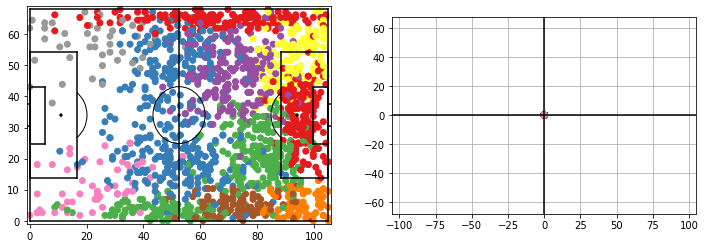

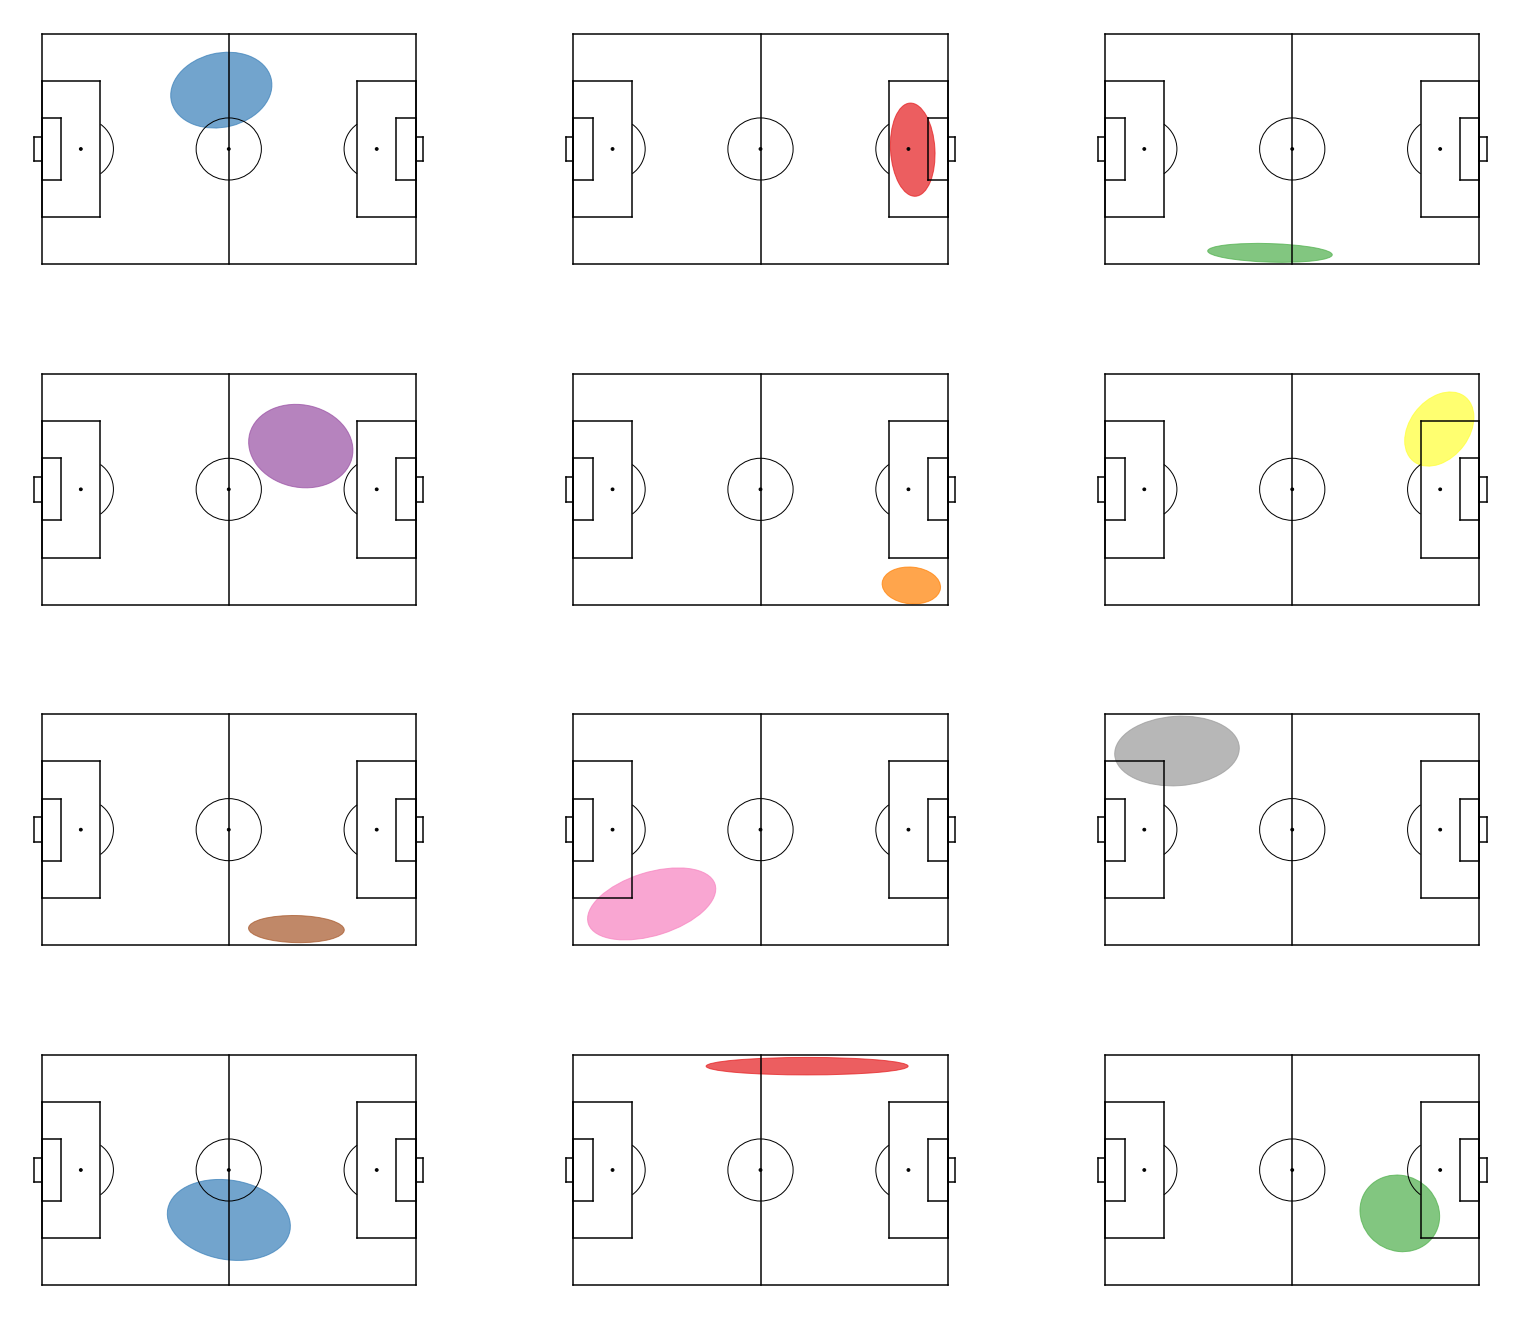

clearance 5 3336


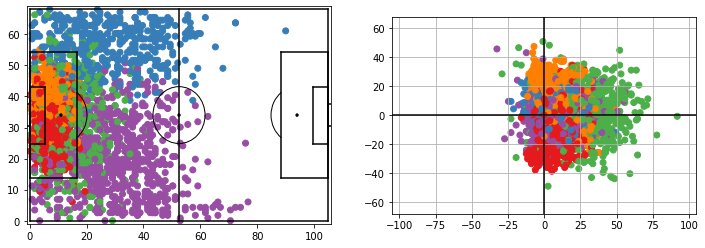

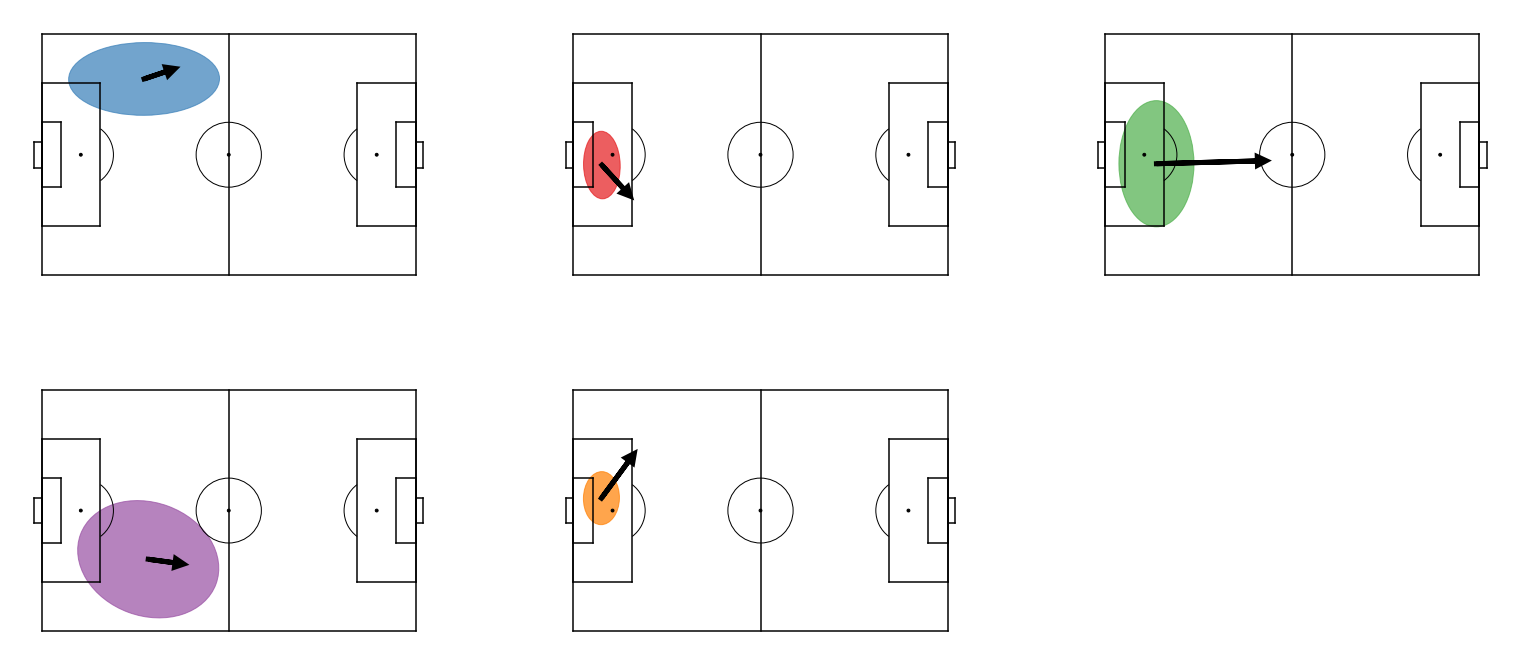

corner 4 650


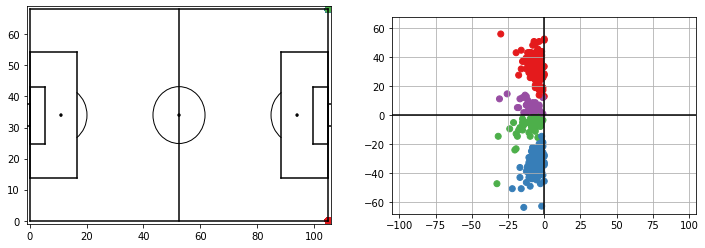

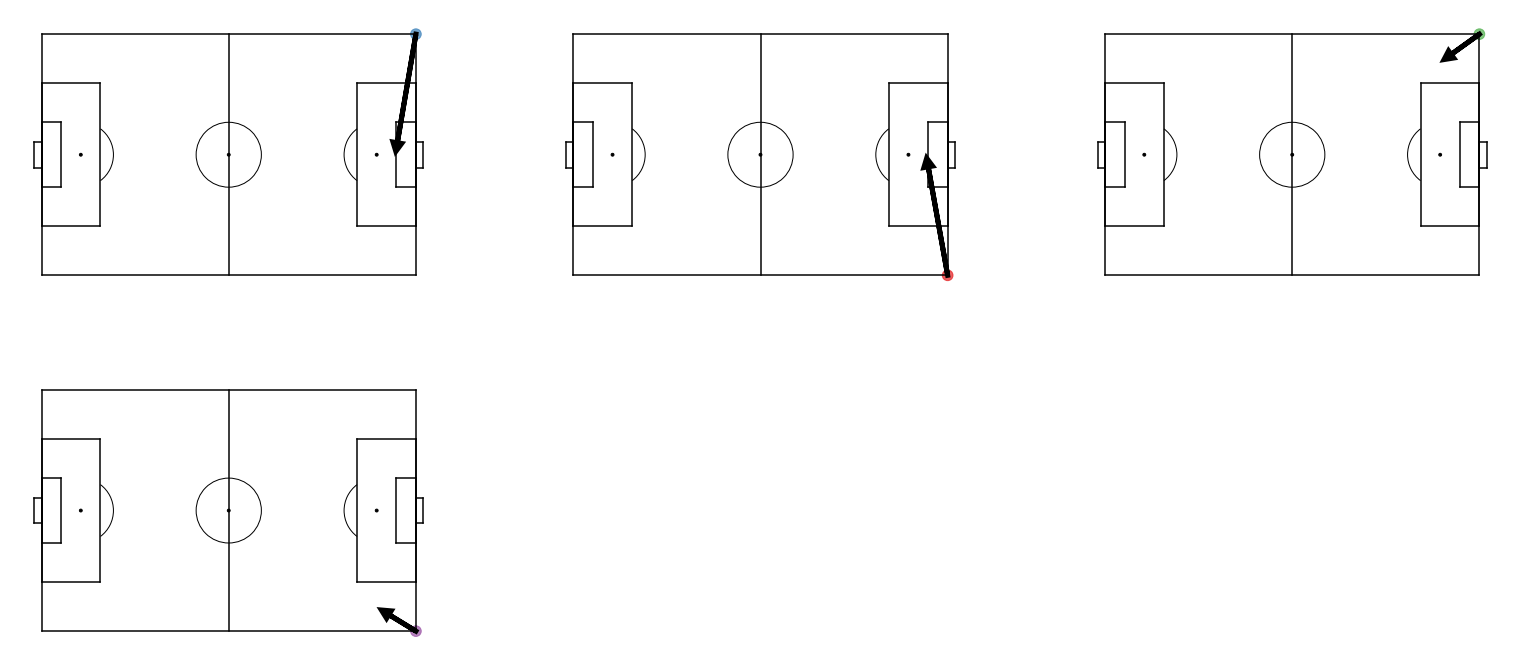

cross 3 1340


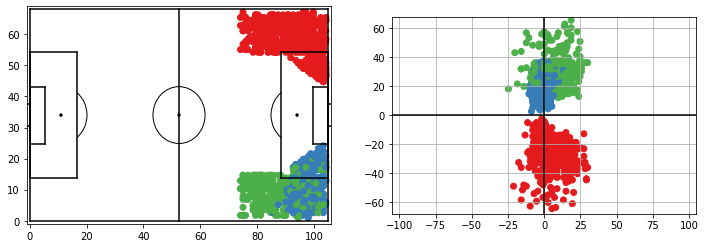

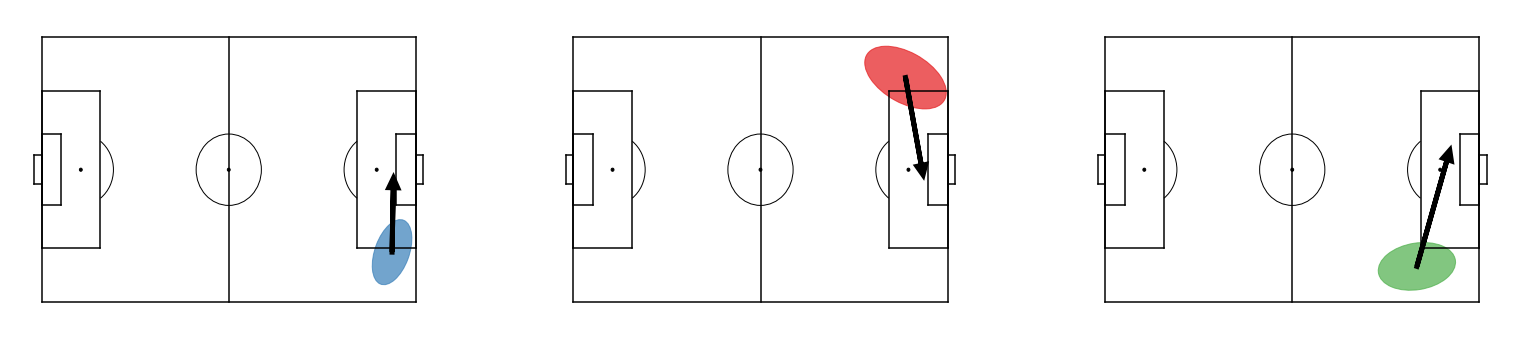

dribble 19 55786


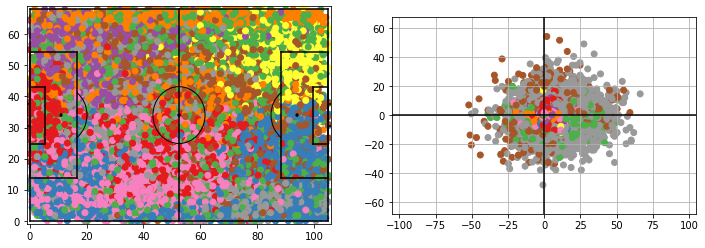

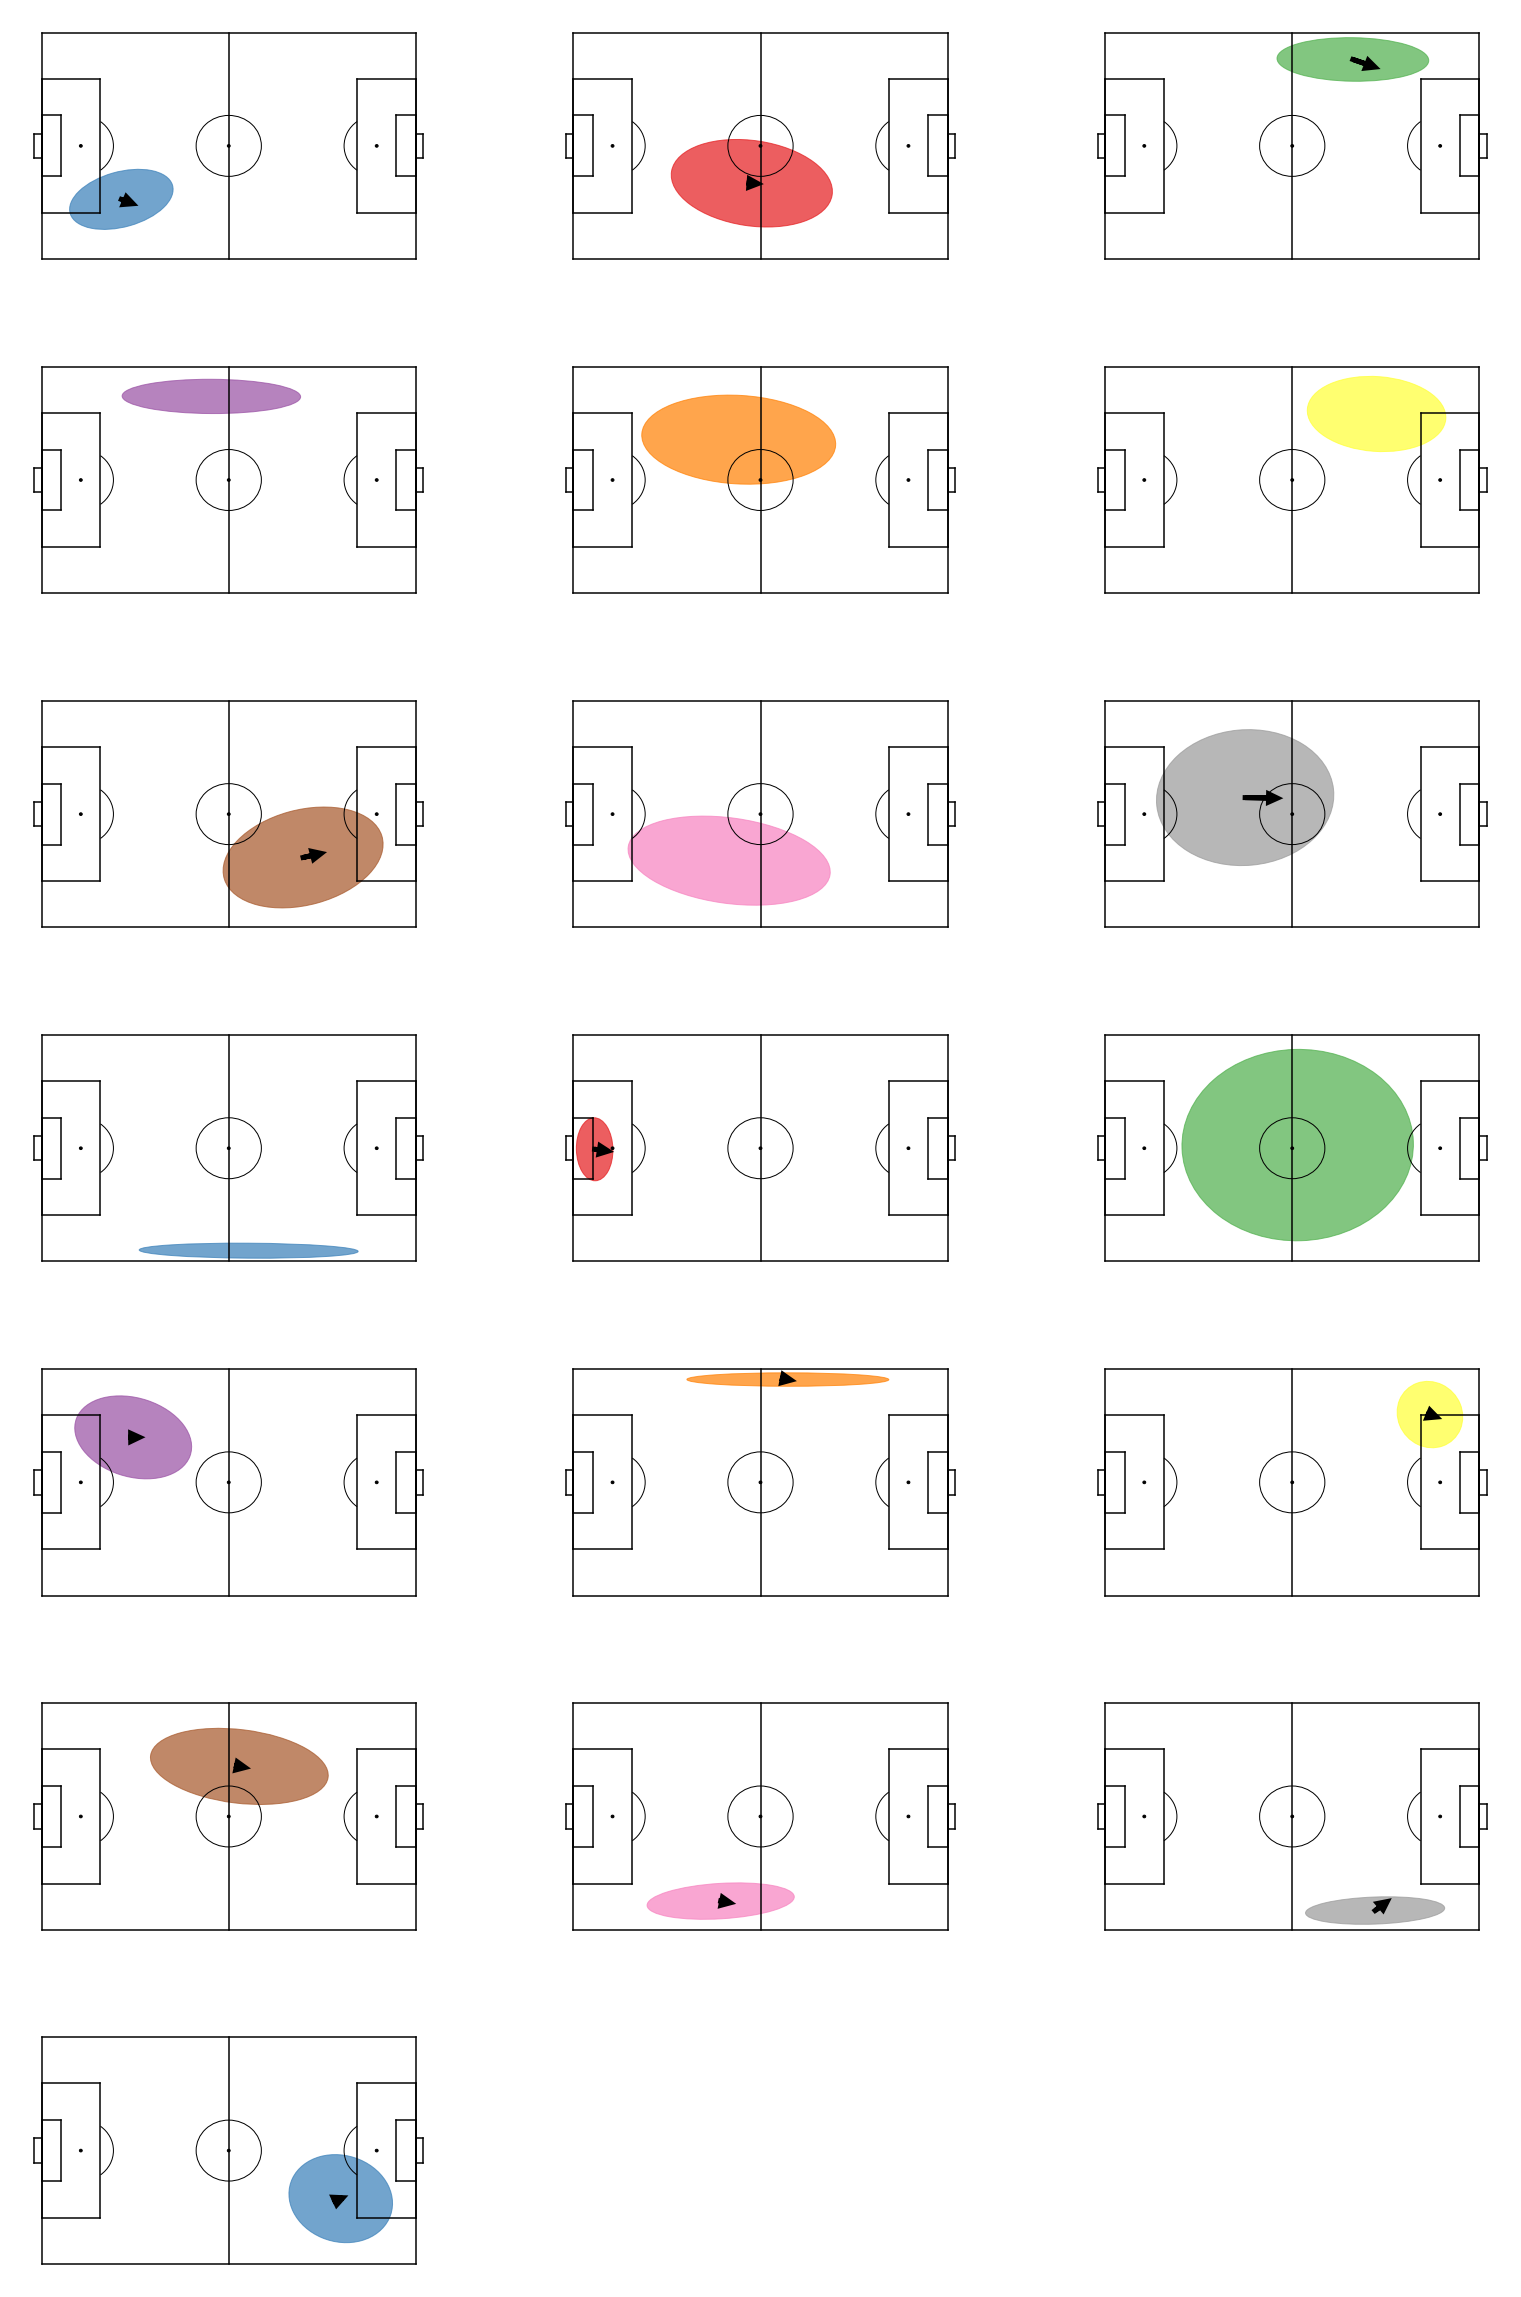

foul 13 1522


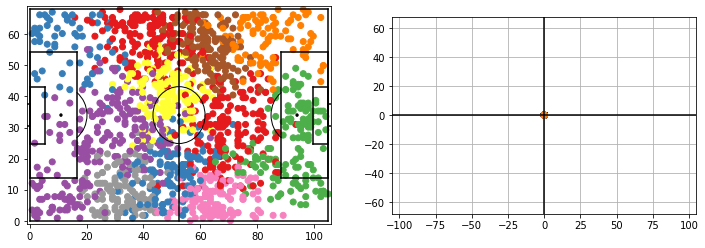

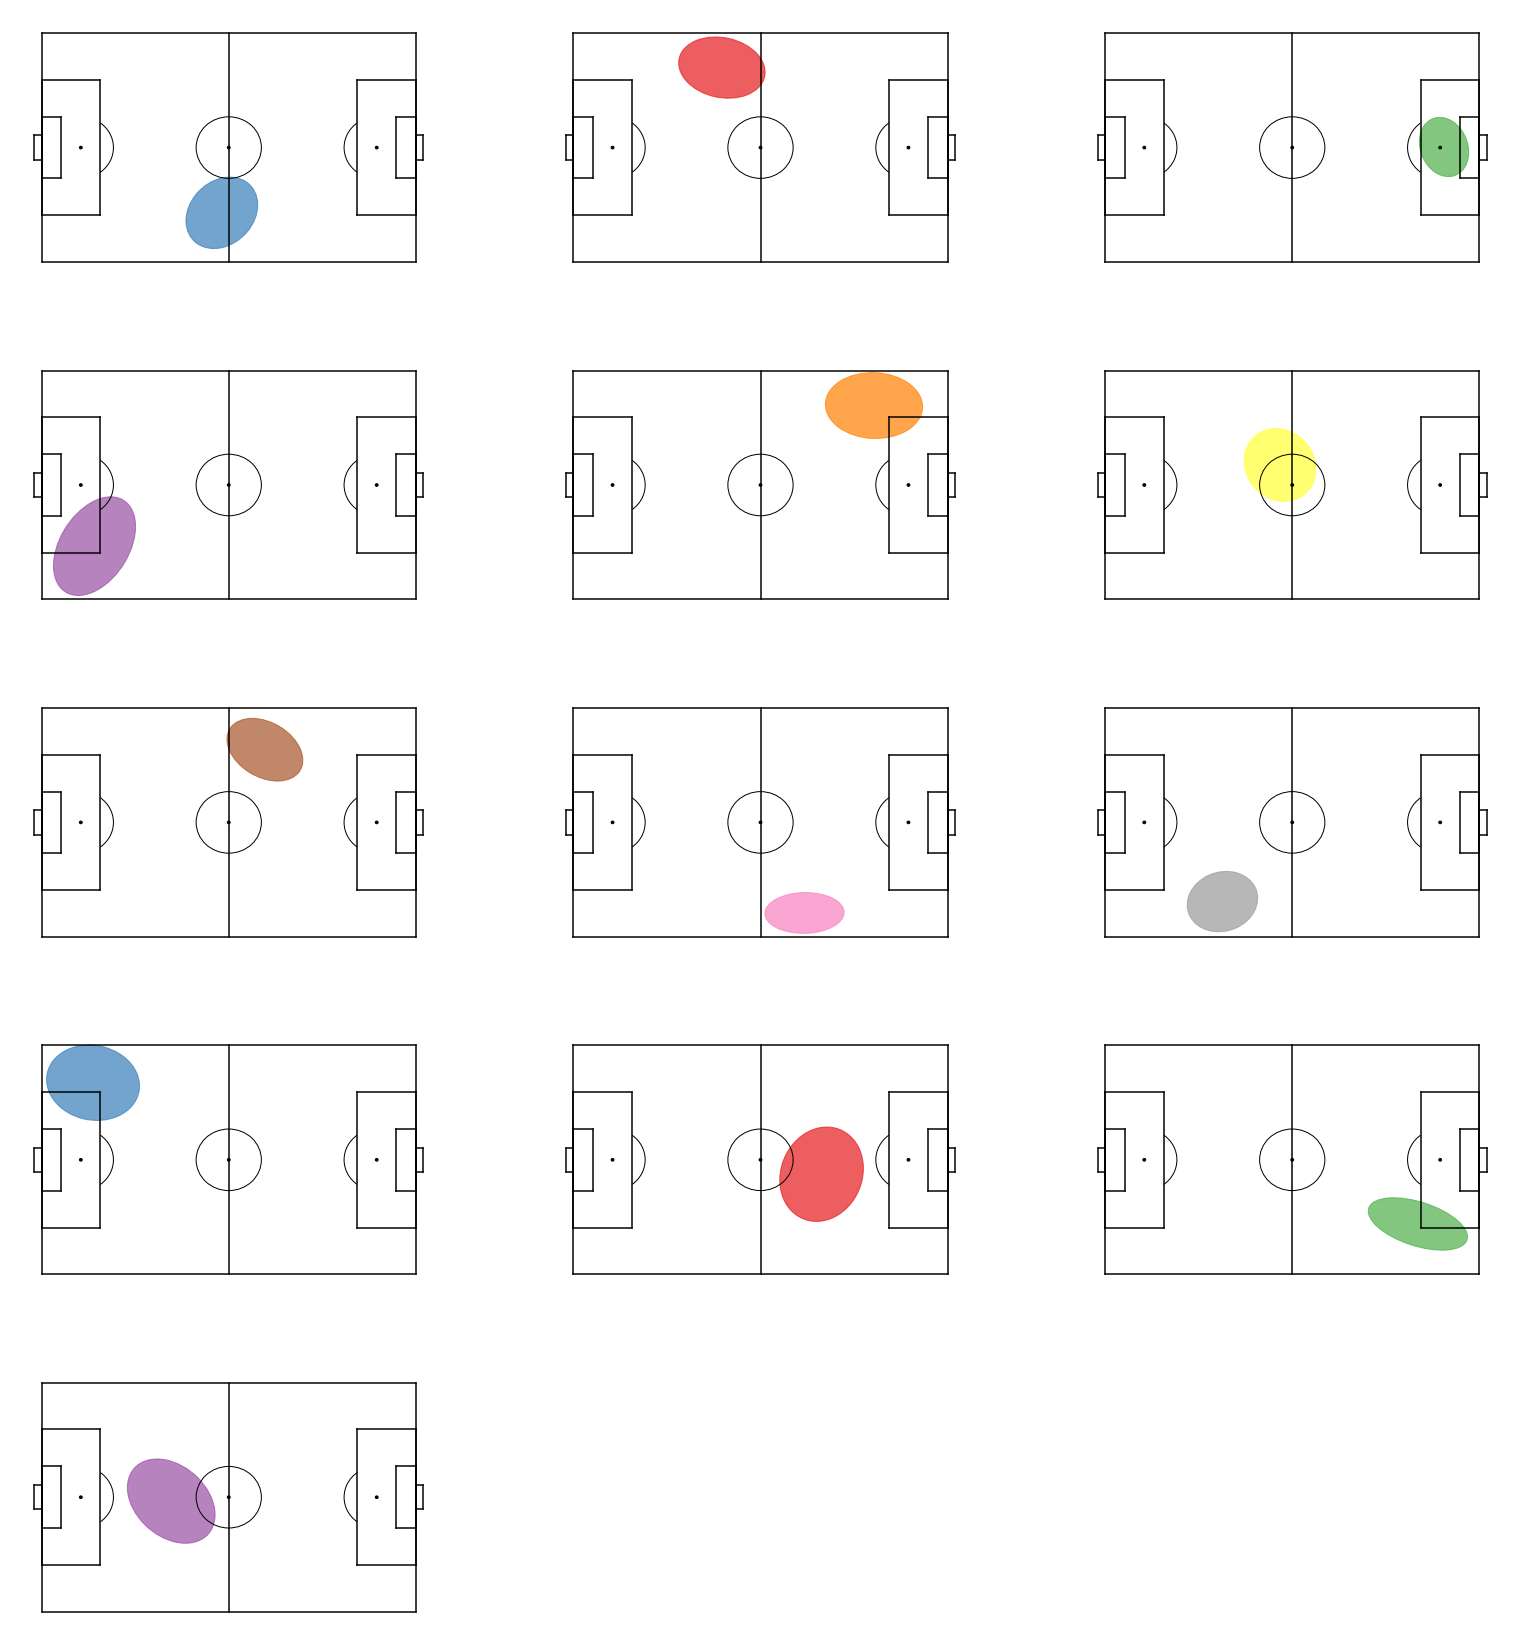

freekick 10 1485


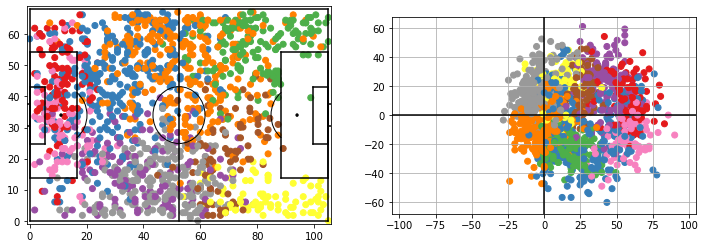

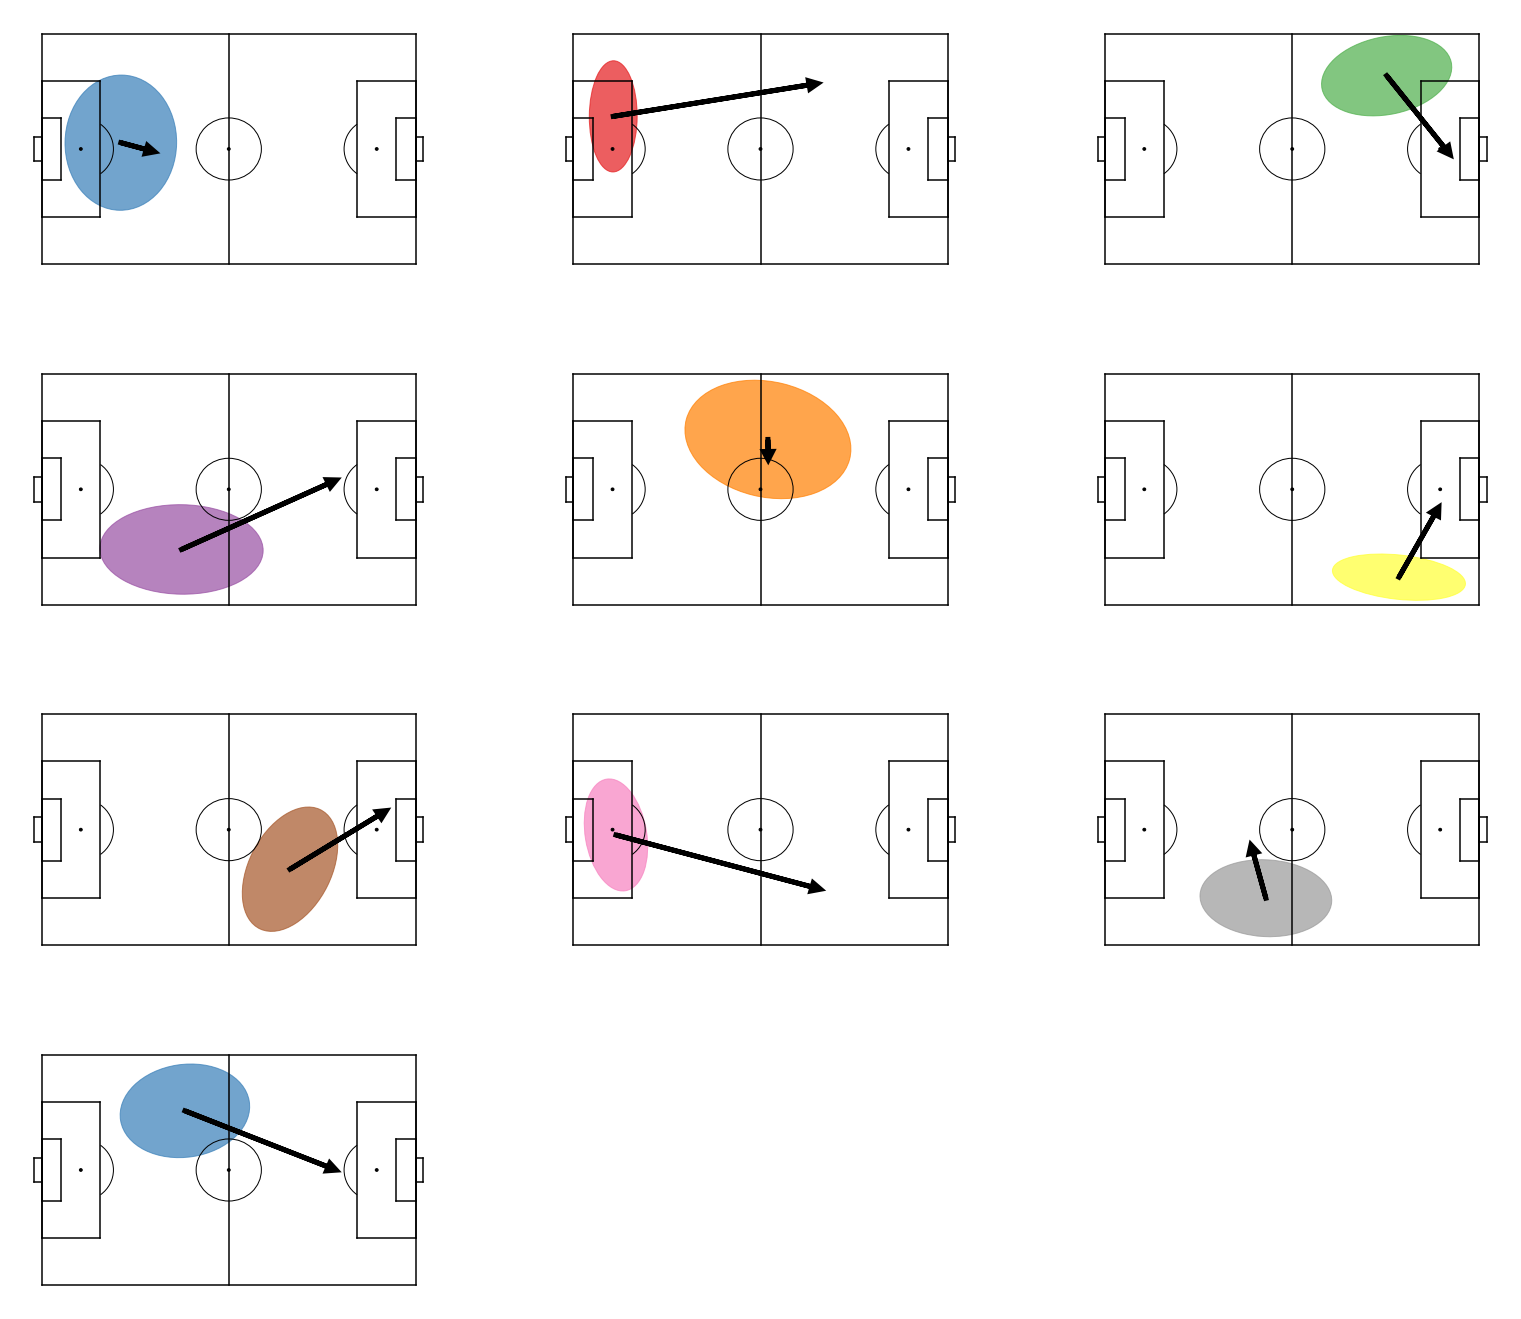

goal 1 181


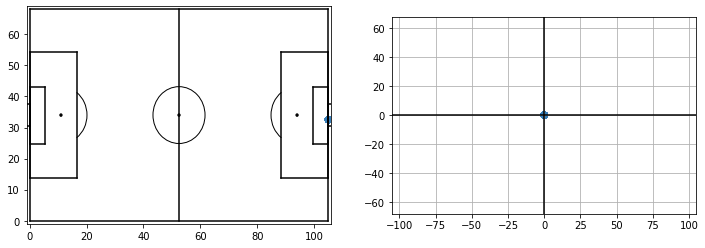

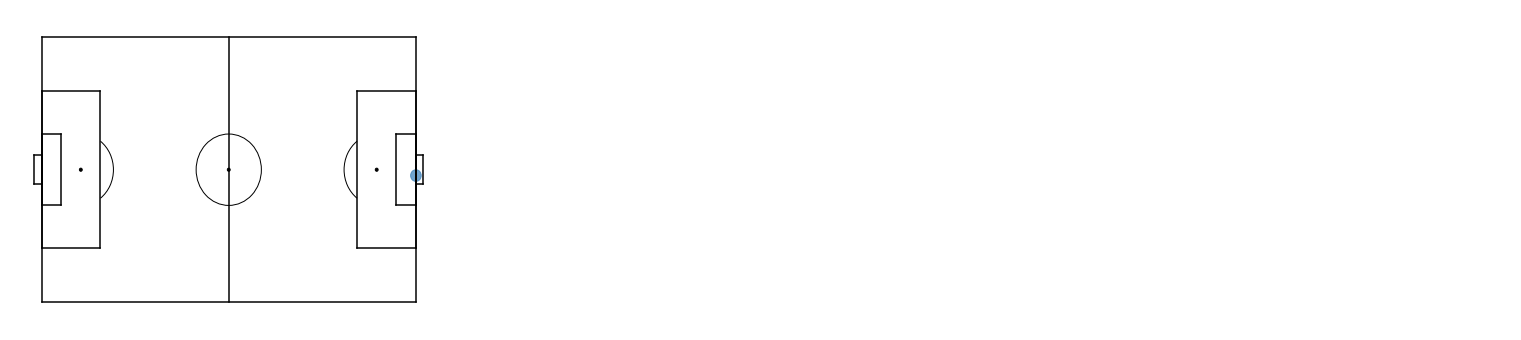

goalkick 5 957


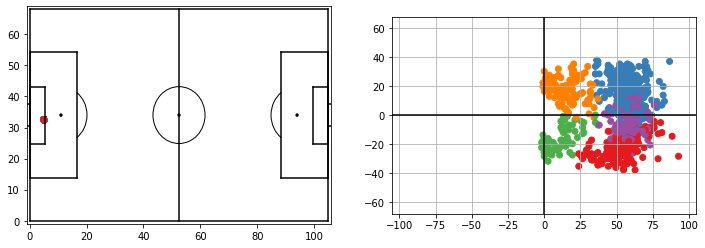

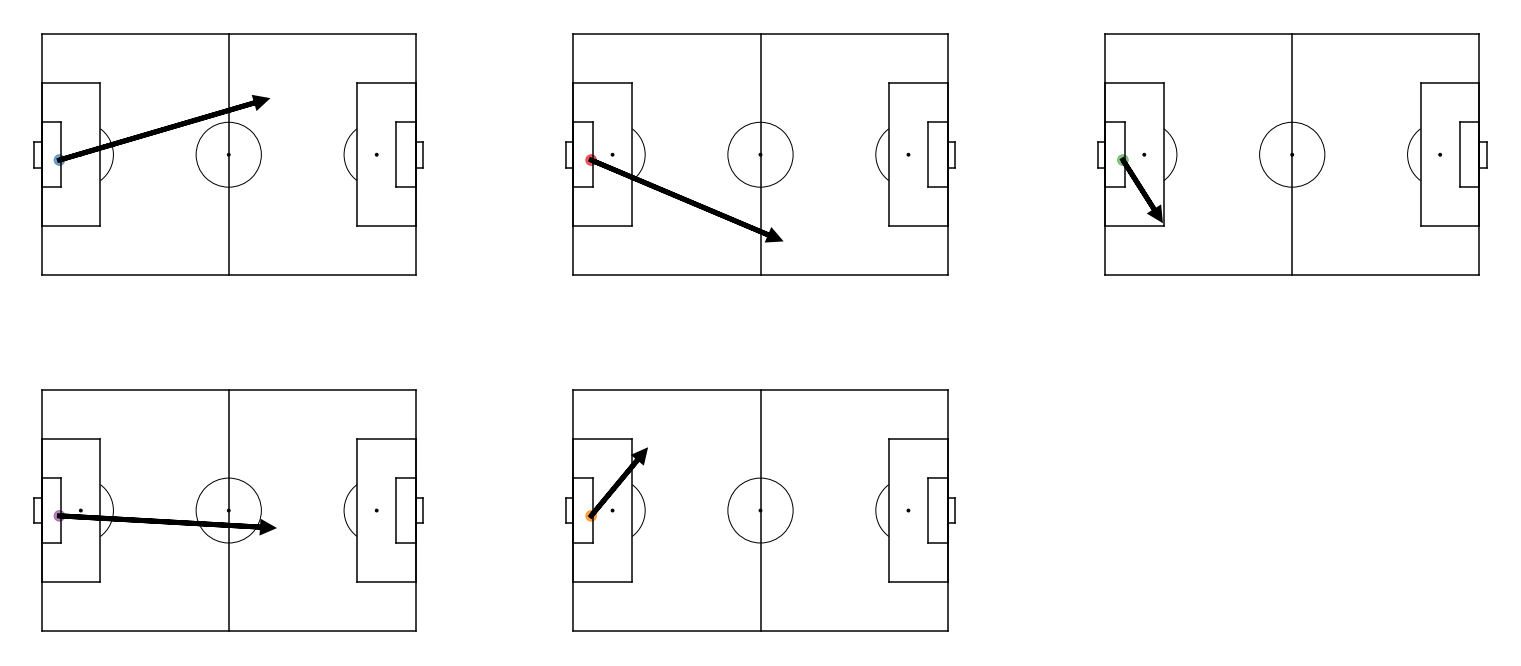

interception 7 12753


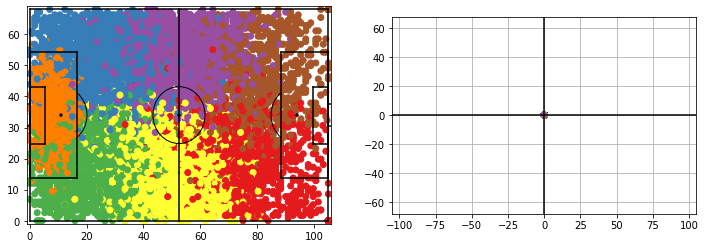

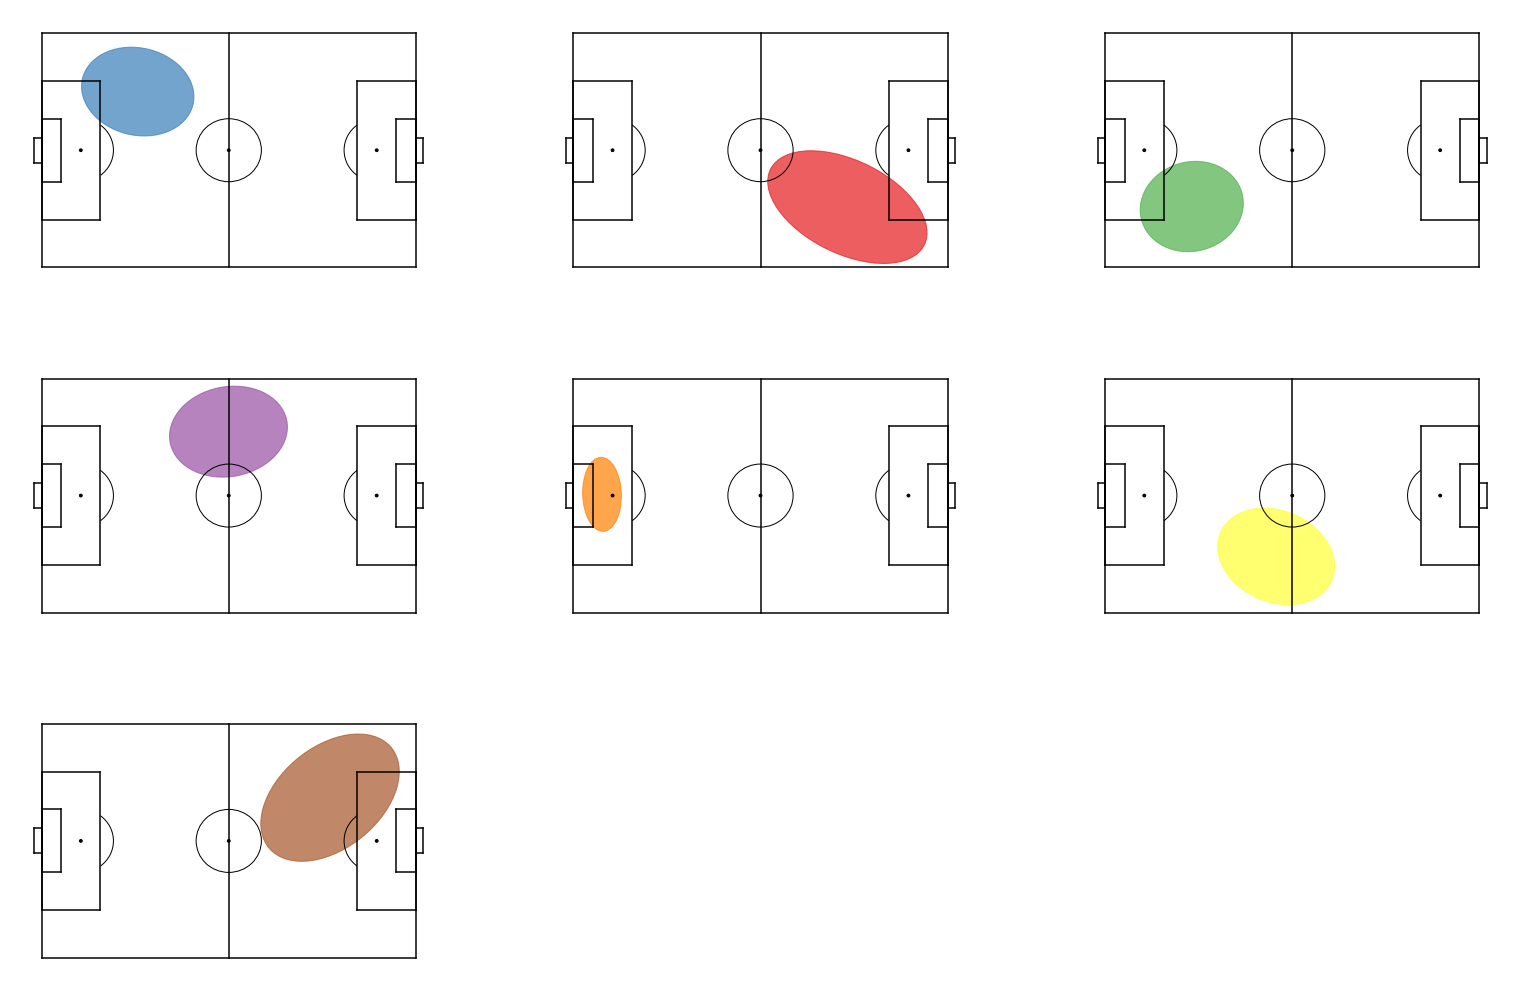

keeper_catch 1 641


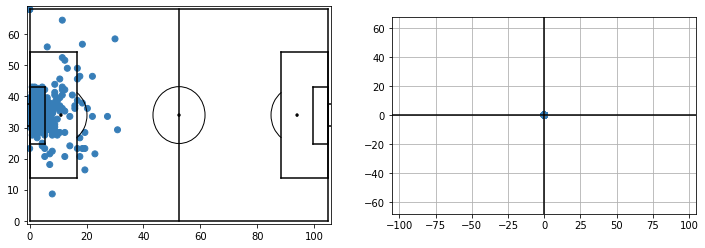

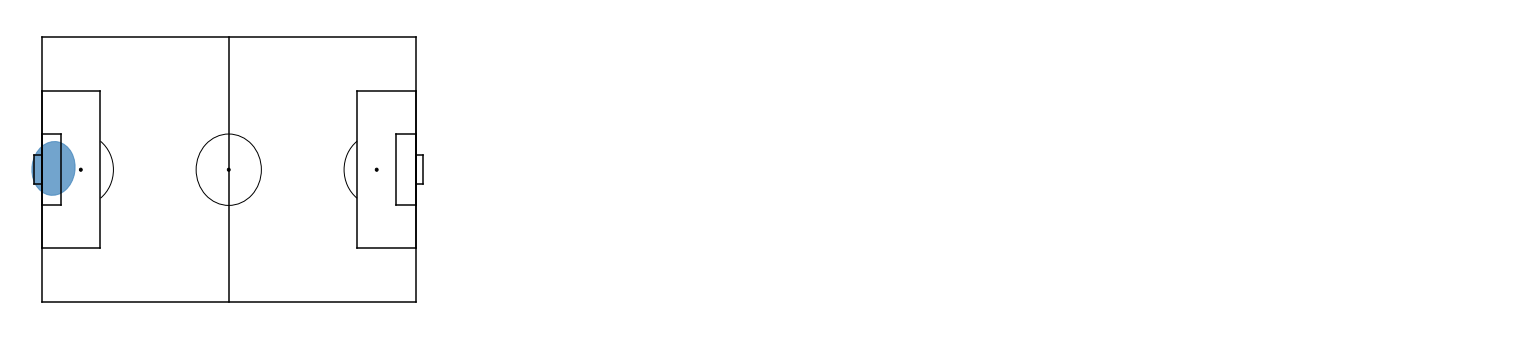

offside 7 207


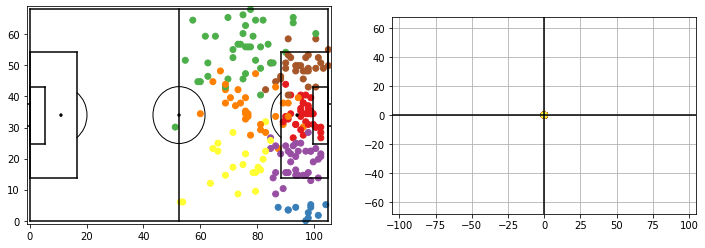

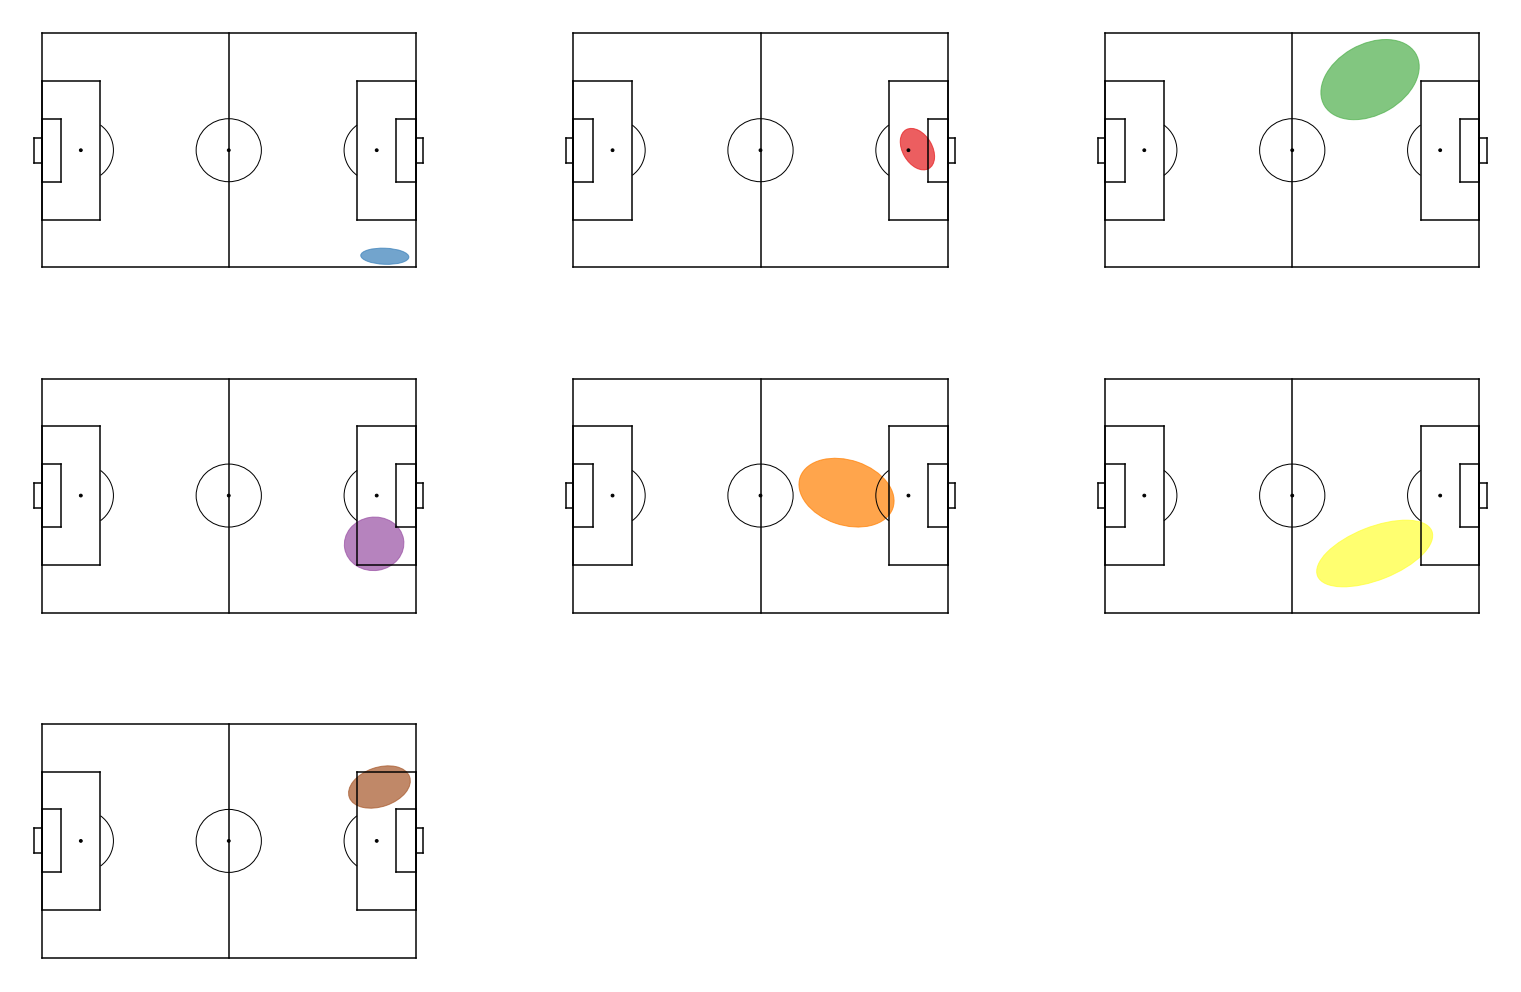

out 12 2555


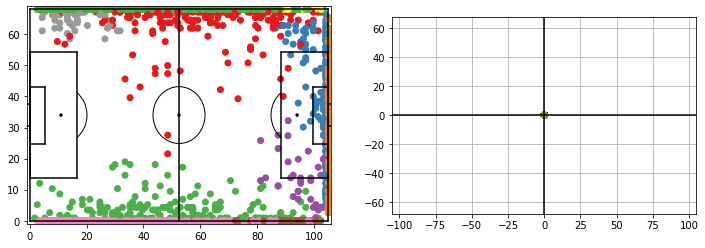

../pattern/vis.py:30: RuntimeWarning: divide by zero encountered in double_scalars
  angle = np.arctan(u[1] / u[0])


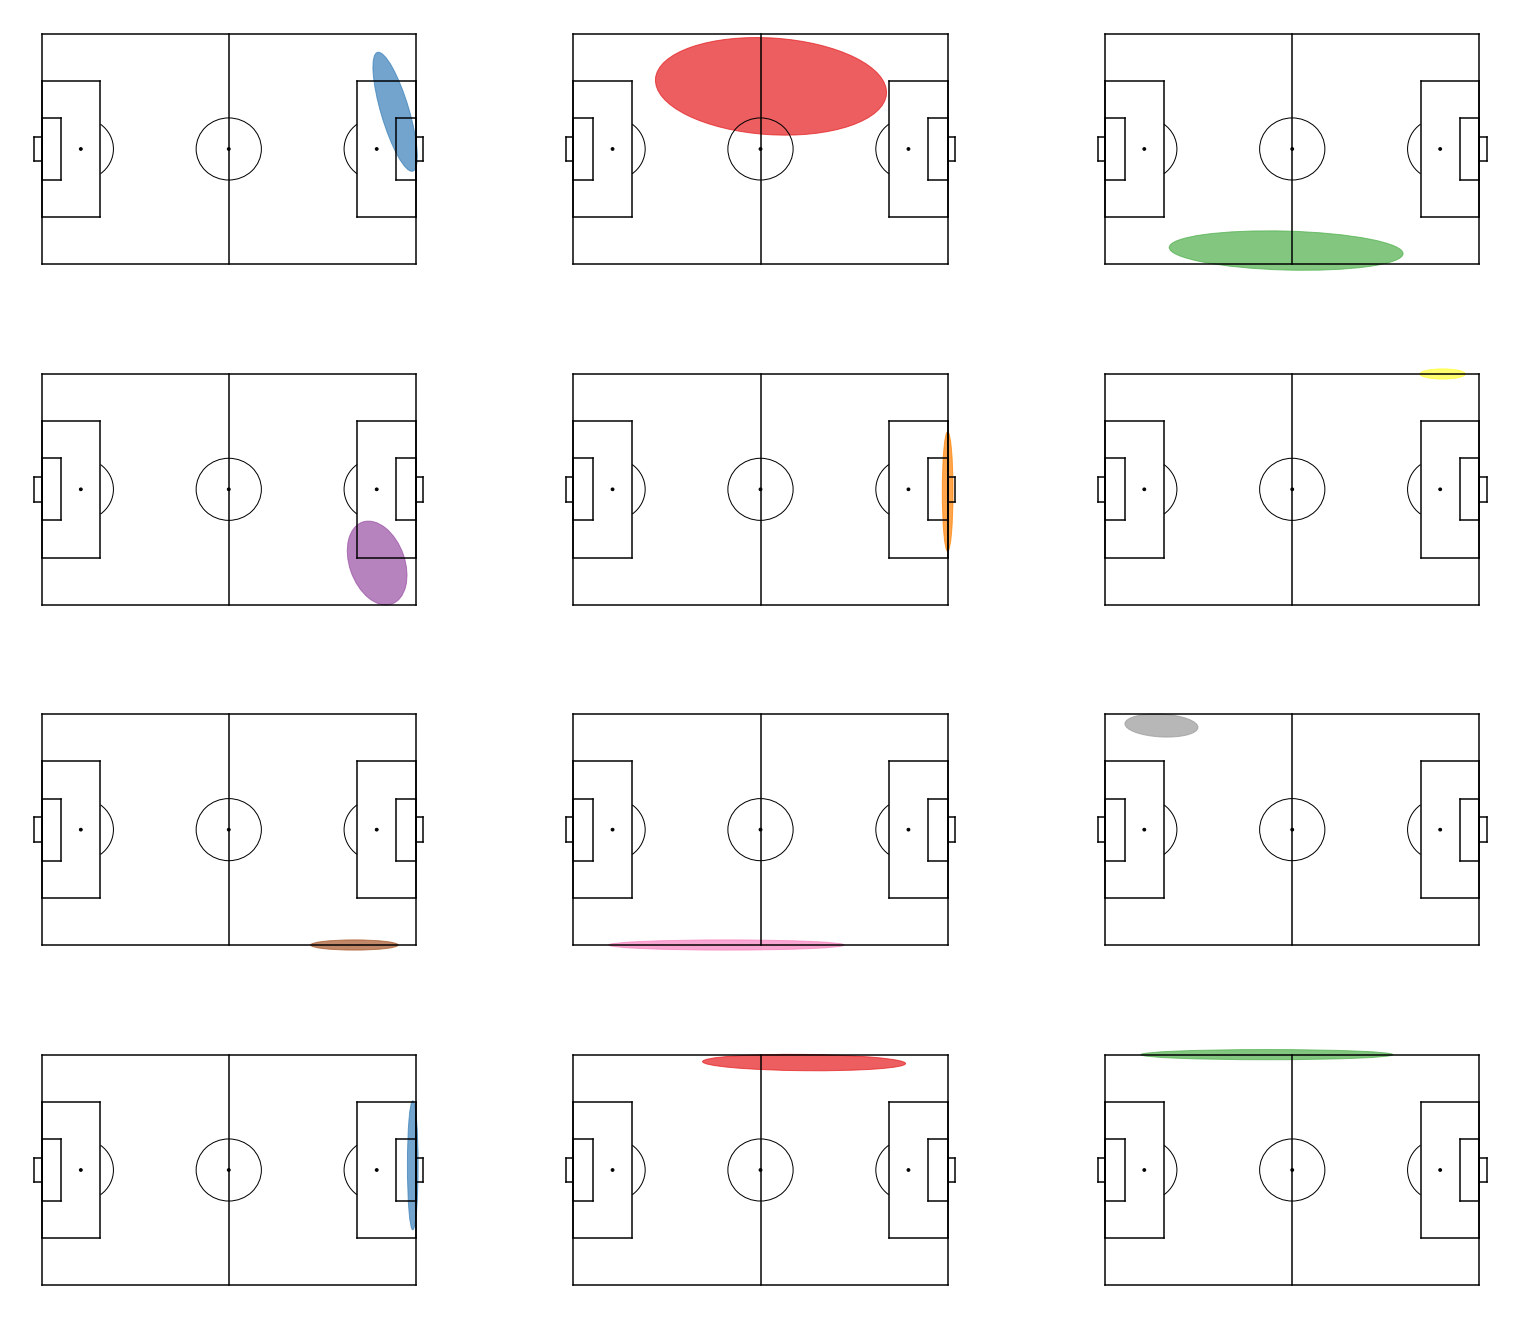

owngoal 1 2


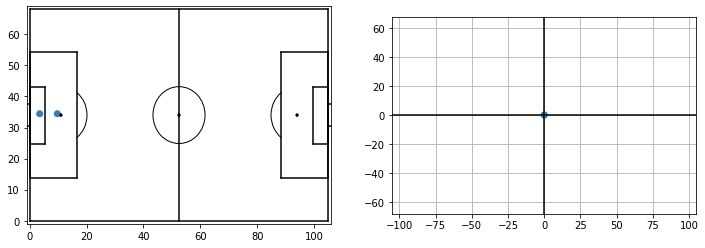

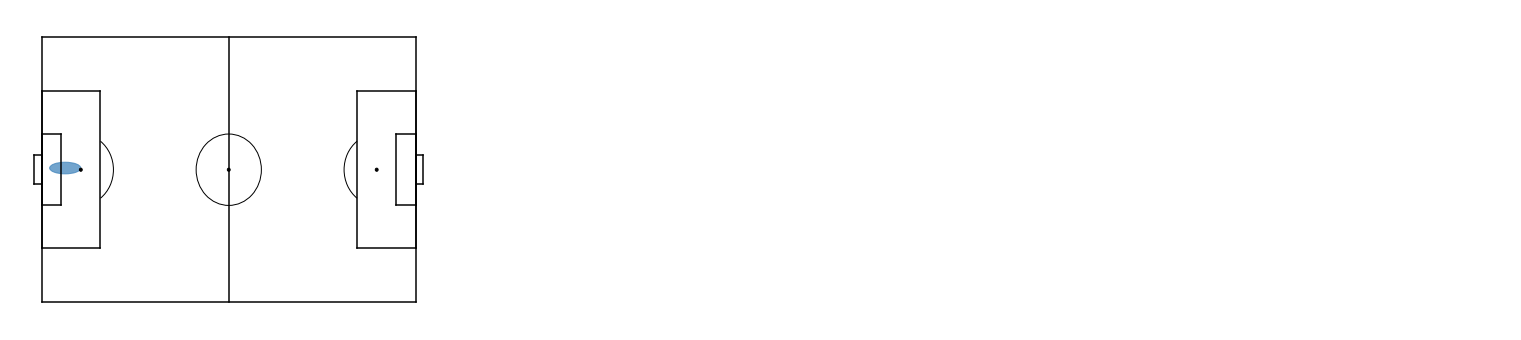

pass 12 56530


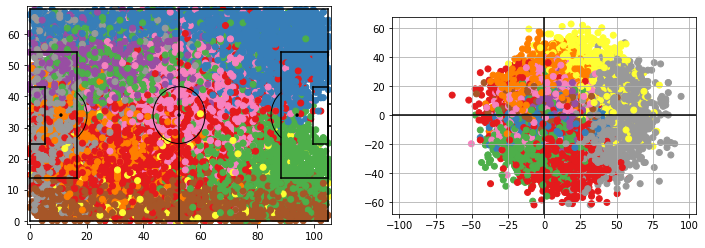

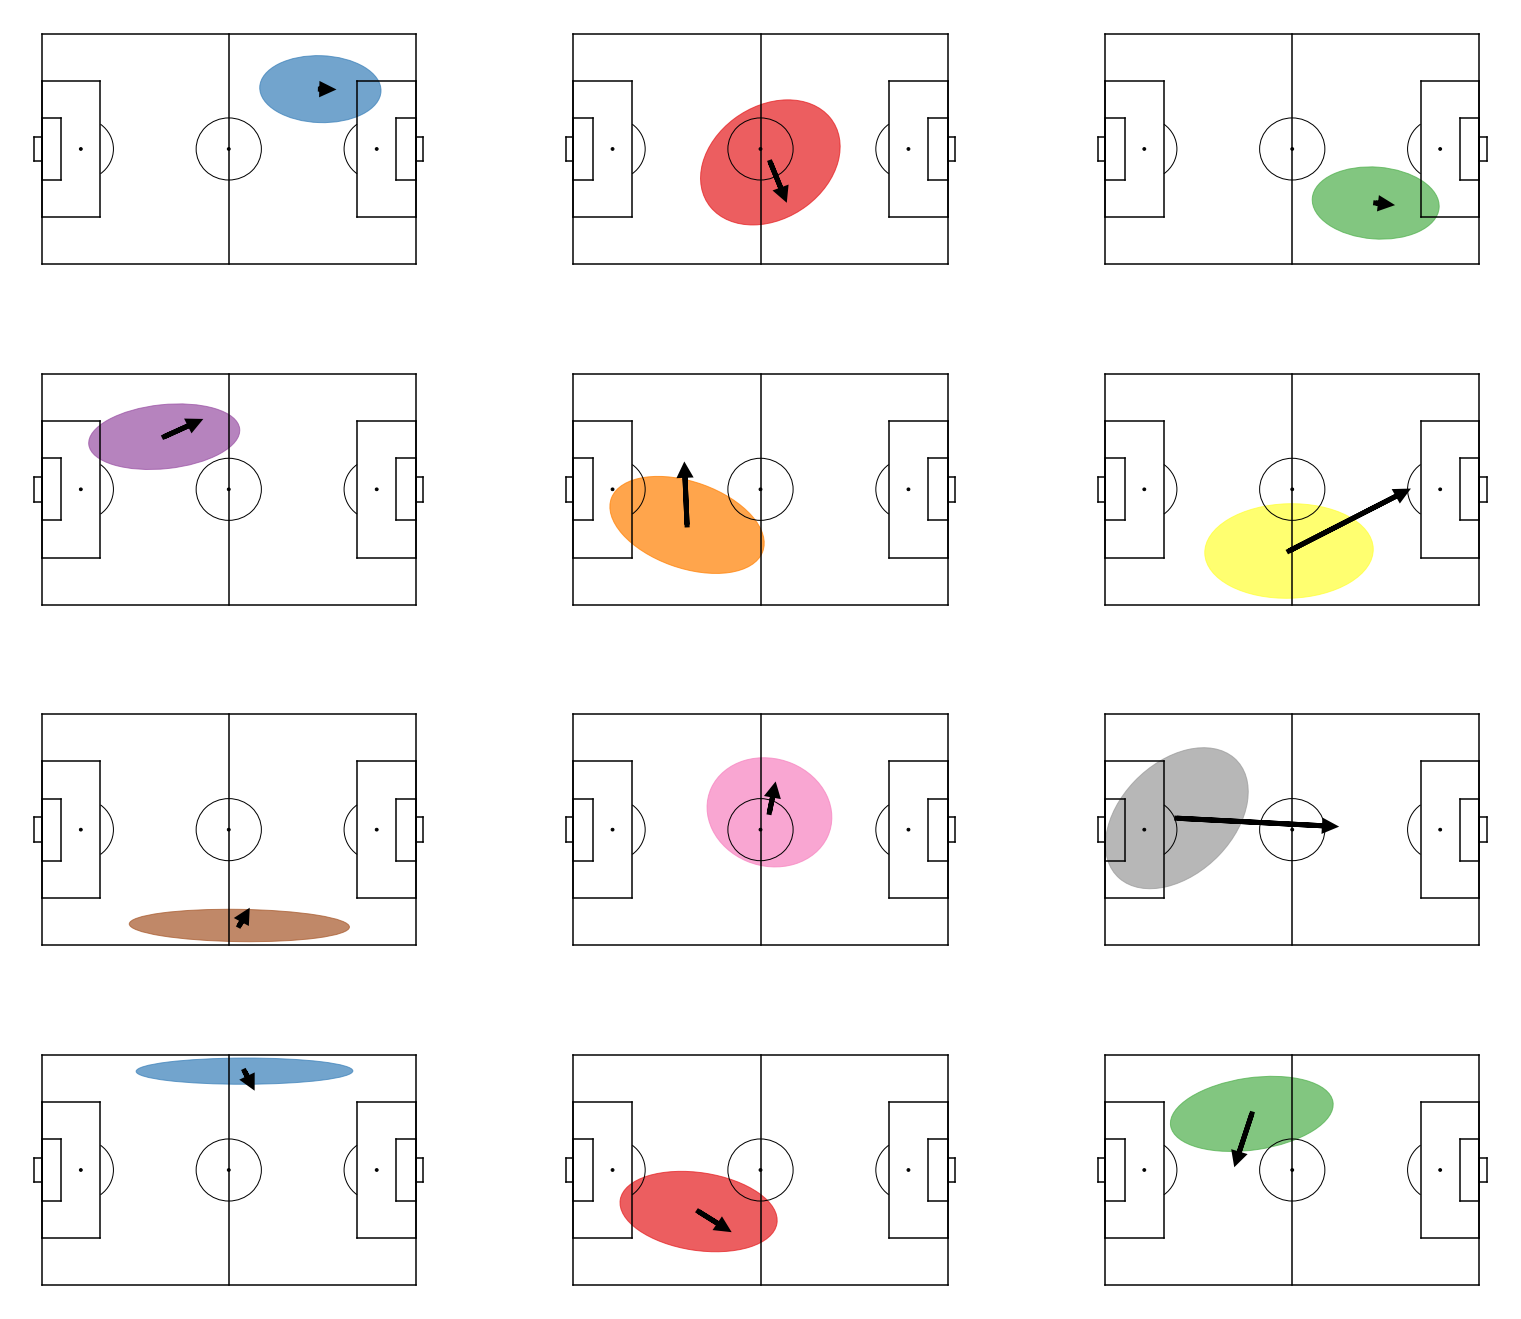

receival 6 51567


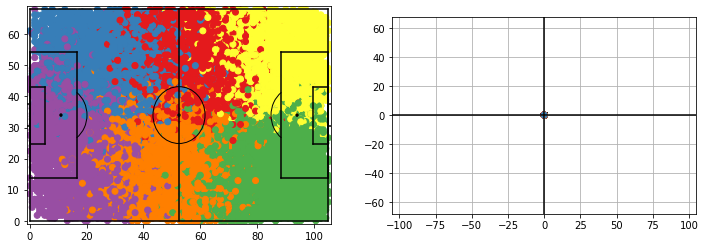

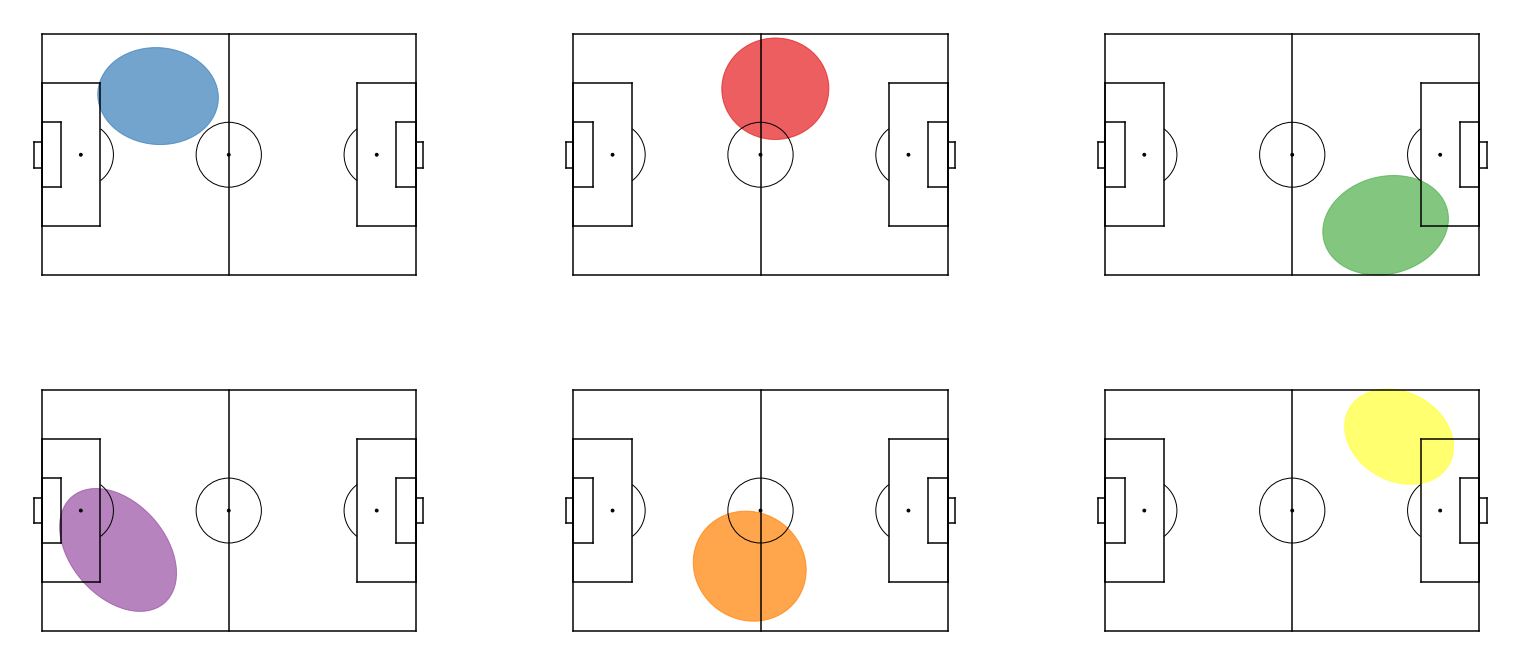

red_card 3 3


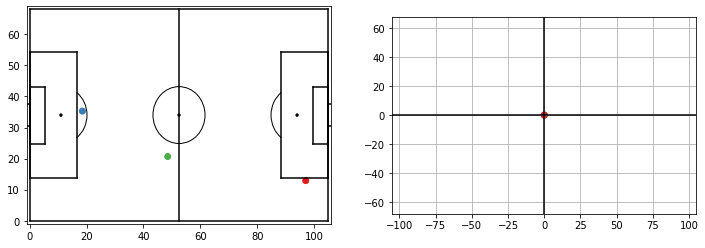

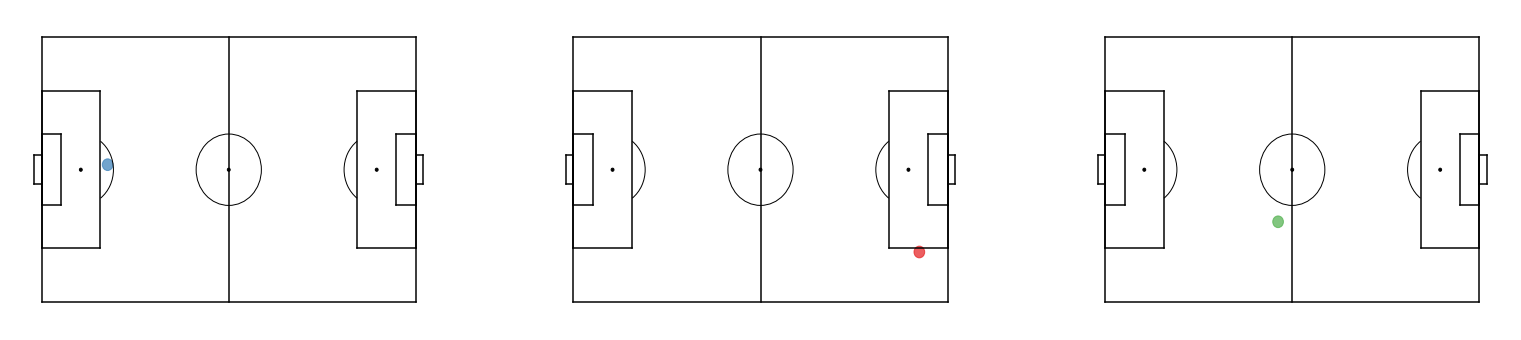

shot 3 1550


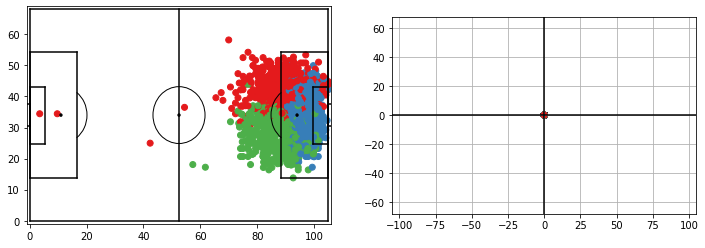

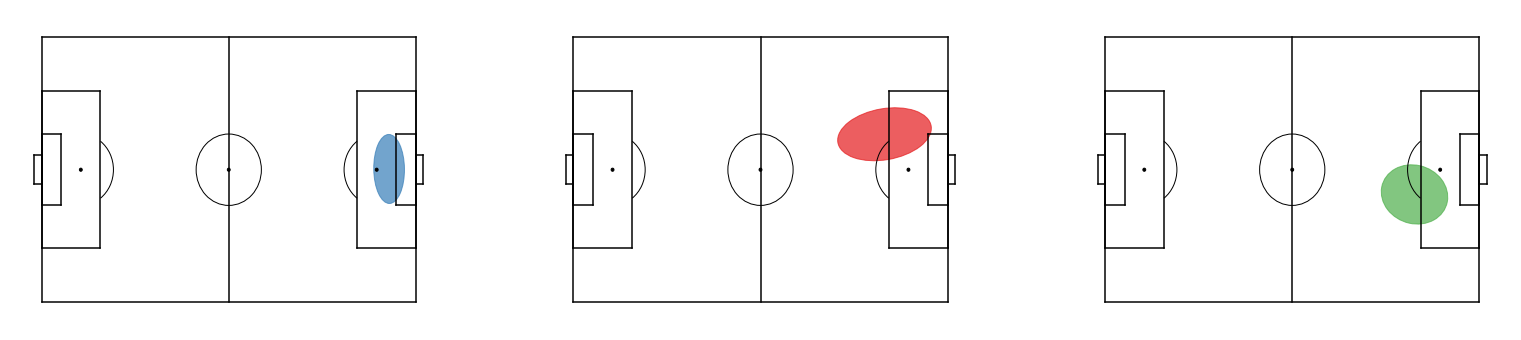

shot_penalty 1 19


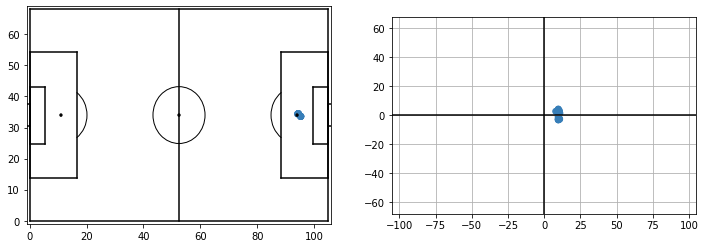

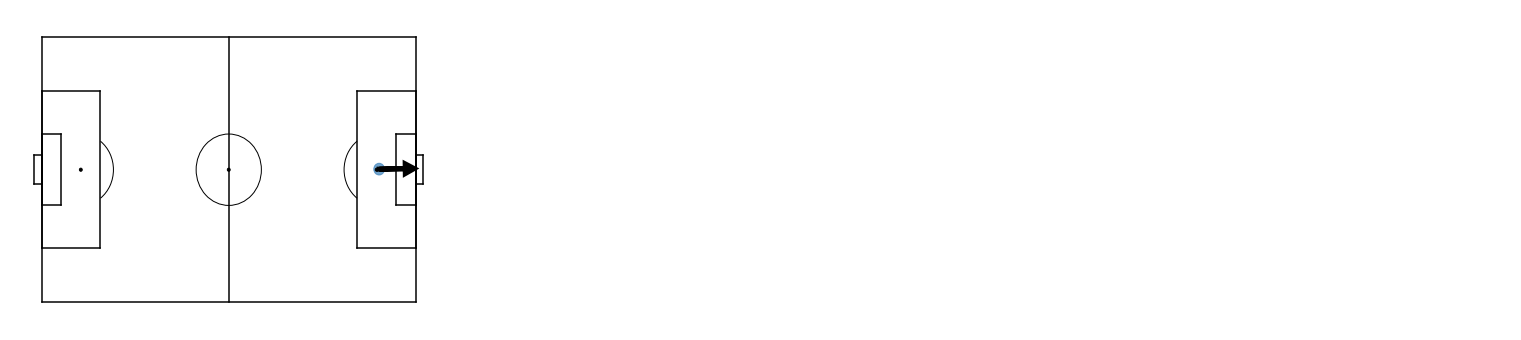

tackle 4 2281


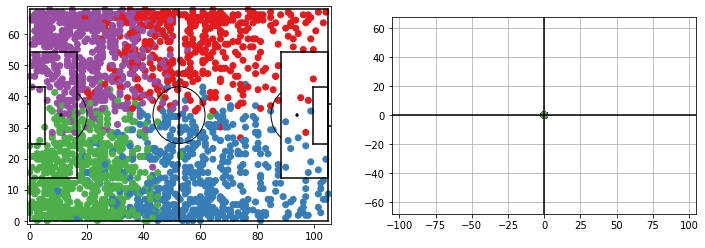

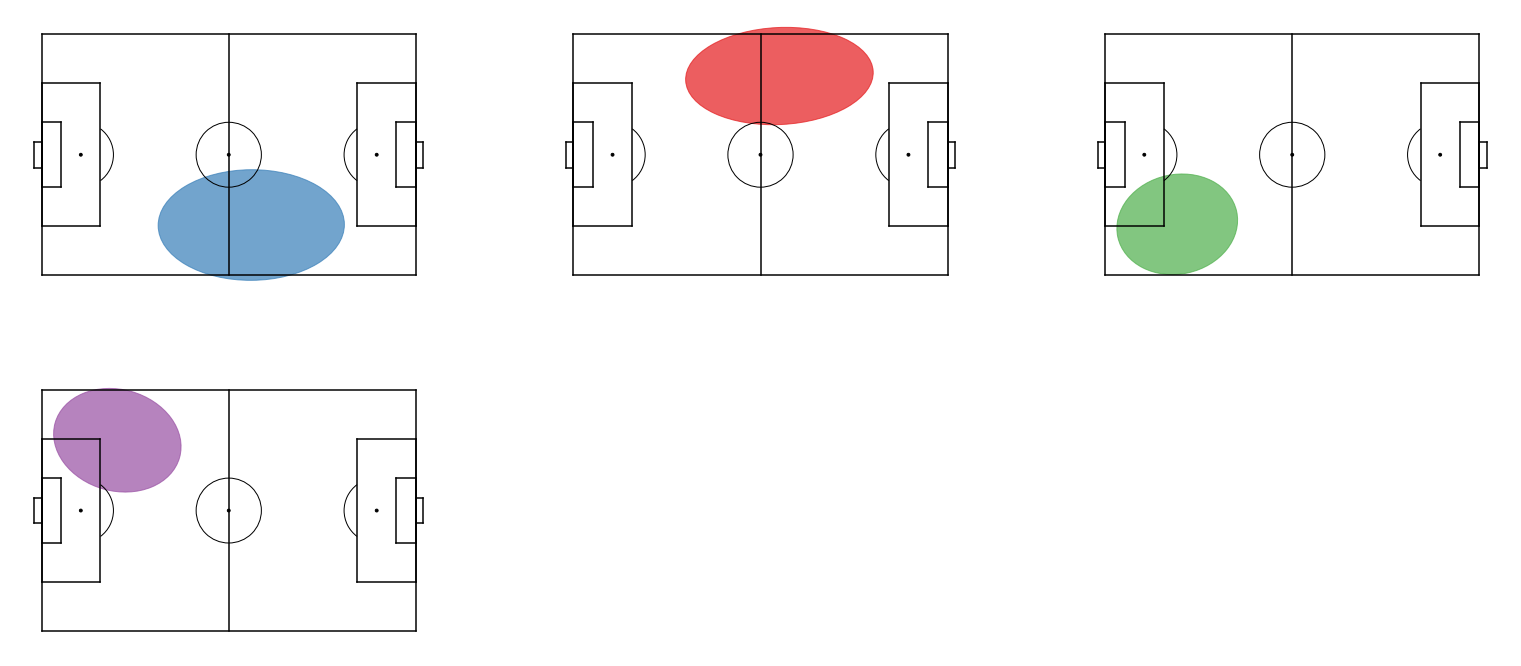

take_on 5 2112


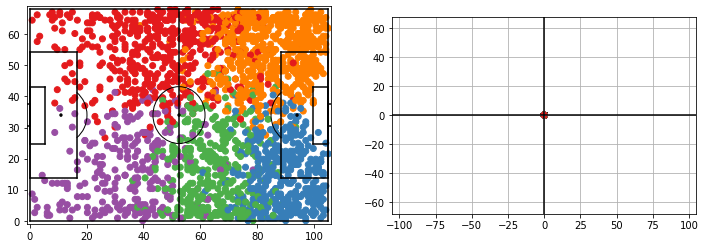

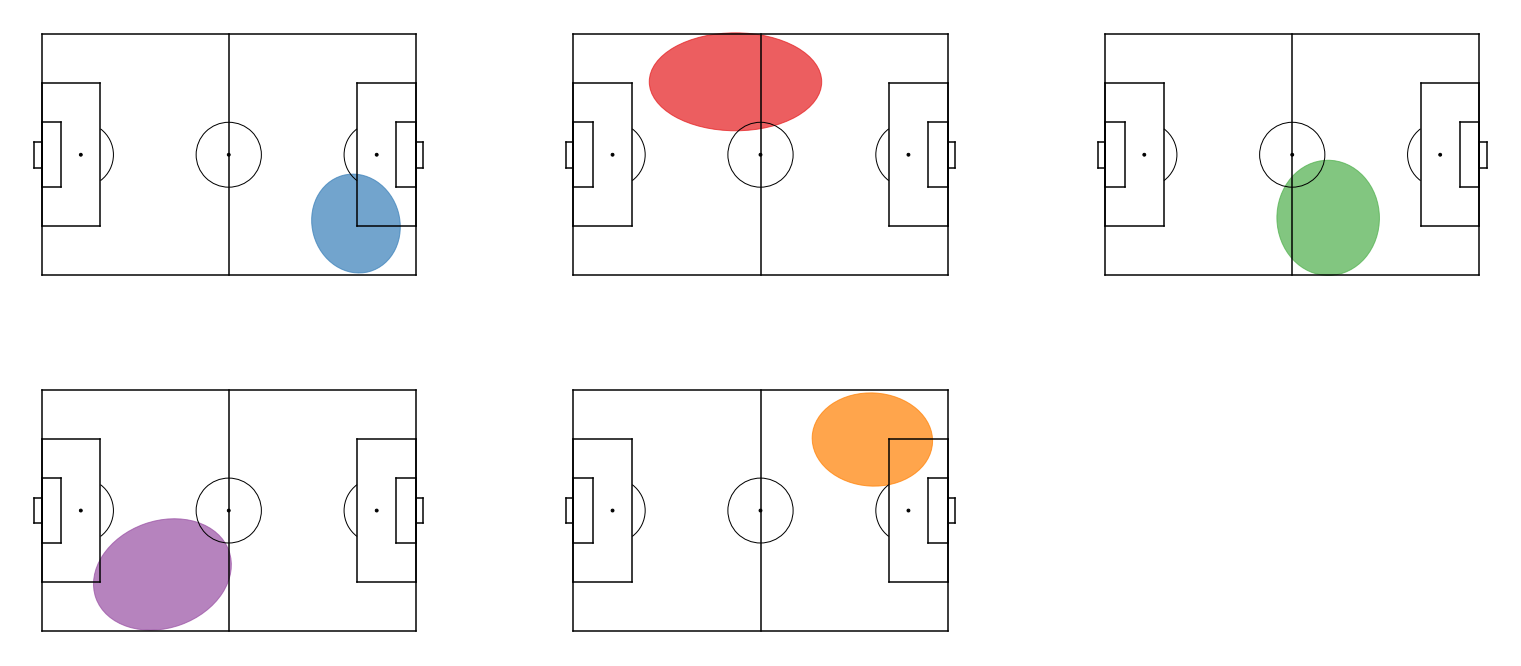

throw_in 8 2733


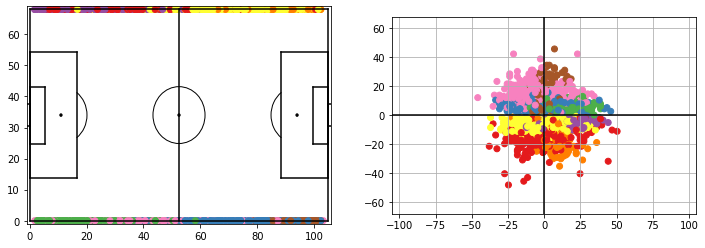

../pattern/vis.py:30: RuntimeWarning: divide by zero encountered in double_scalars
  angle = np.arctan(u[1] / u[0])


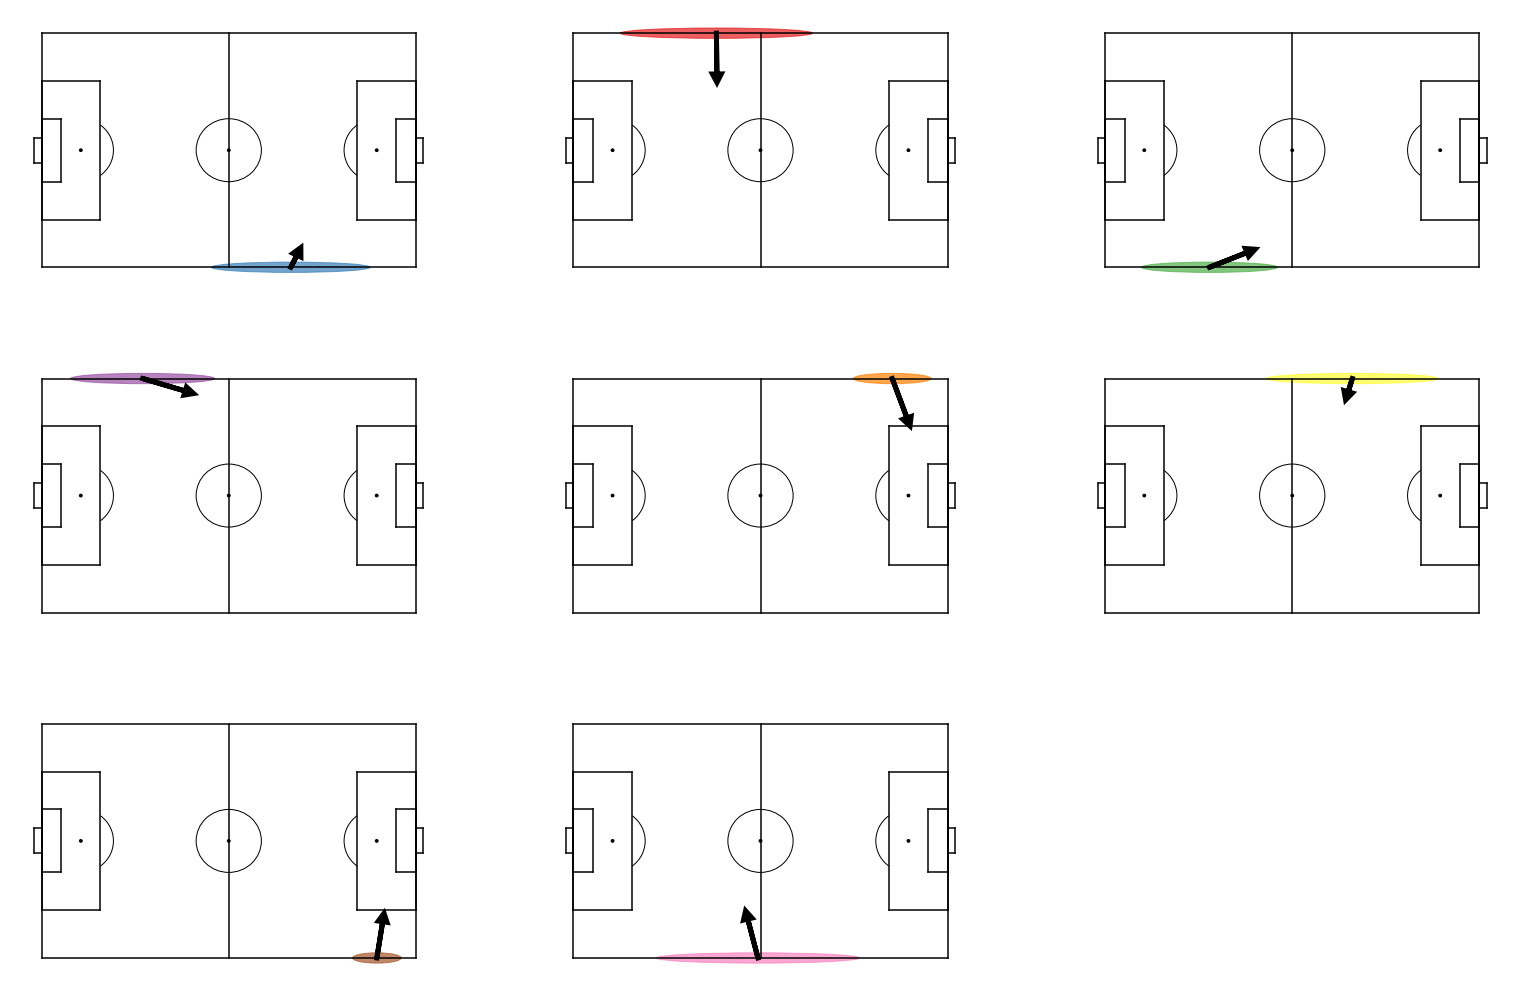

yellow_card 8 185


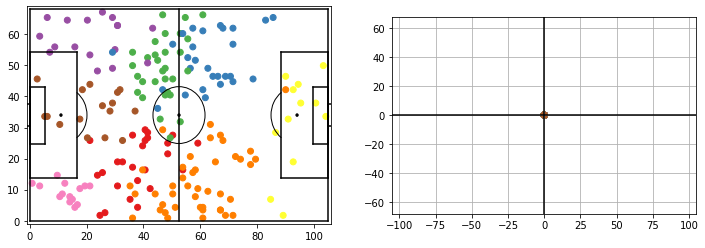

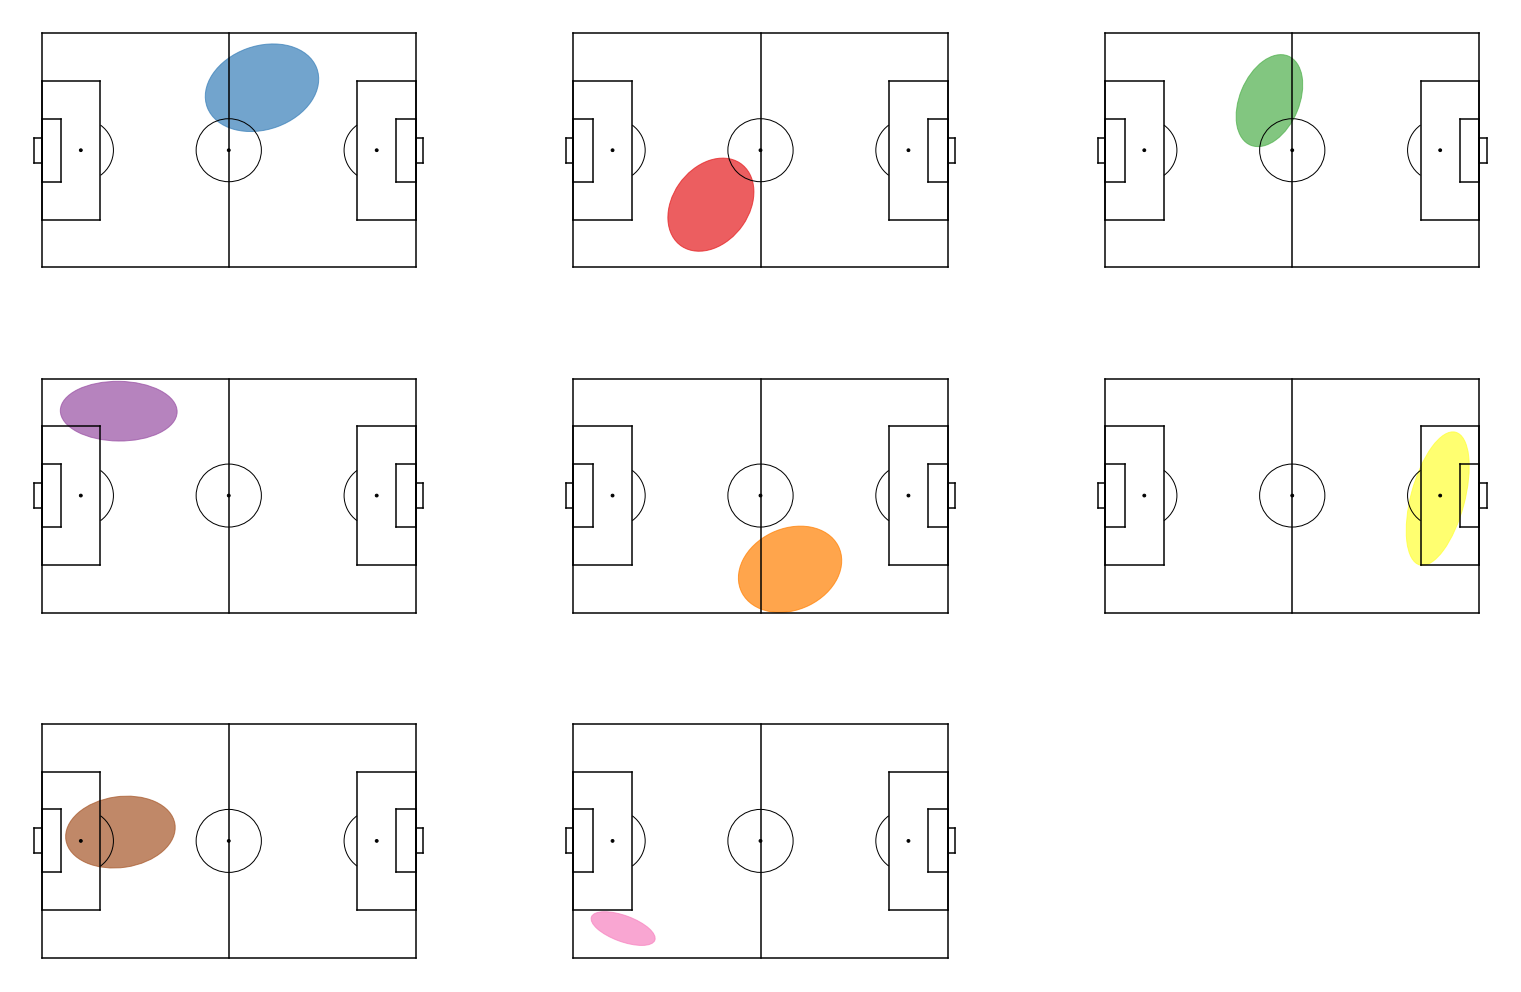

In [224]:
import pattern.vis as vis
for k, gmm in sorted(list(gmme.models.items())):
    df = a[a.type_name == k]
    print(k,gmm.n_components,len(df))
    #vis.plot_gmm(gmm)
    vis.plot_gmm_actions(gmm,df,gmme.cols,samplefn="uni")
    vis.plot_components_arrows(gmm,cols=3)

In [225]:
probas = gmme.predict_proba(a)

In [226]:
ucprobas = pat.uncouple_probabilities(probas,a.is_home.values)
ucprobas
ucprobas.values.sum()

199999.99999999994

(199999, 300)


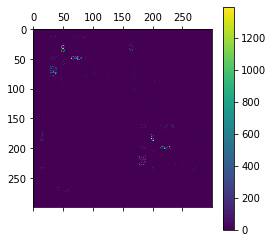

In [227]:
prev = ucprobas.values[:-1]
nex = ucprobas.values[1:]
print(prev.shape)
trans = np.dot(prev.T,nex)
plt.matshow(trans)
plt.colorbar()
plt.show()
trans /= trans.sum()
# for i in range(len(trans[0])):
#     trans[i,:] /= trans[i,:].sum()
trans.sum()
ori_trans = trans

In [228]:
trans1 = ori_trans.copy()
for _i in range(10):
    print(trans1.sum())
    trans1 = np.dot(ori_trans.T,trans1)
    trans1 /= trans1.sum()

1.0
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
1.0000000000000002
0.9999999999999999
1.0


(0.0033171722813303776, -0.005156012927876239)

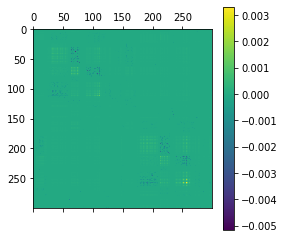

In [192]:
delta_trans = trans1 - ori_trans
plt.matshow(delta_trans)
plt.colorbar()
plt.show
delta_trans.max(), delta_trans.min()

In [194]:
trans = delta_trans
trans = trans1

In [195]:
trans.sum()

0.9999999999999998

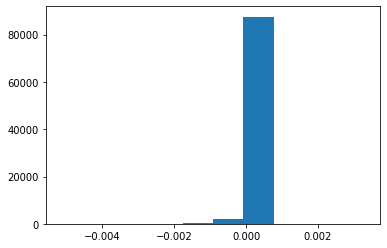

In [196]:
plt.hist([p for p,i,j in probs])
plt.show()

0.0069781590840436985 185 198
pass8_opp (red) -> receival2_opp (blue)


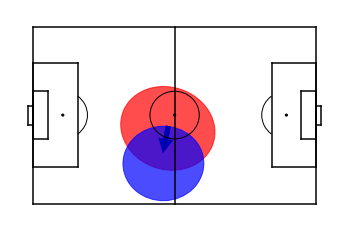

0.00667742411576694 30 49
pass3 (red) -> receival3 (blue)


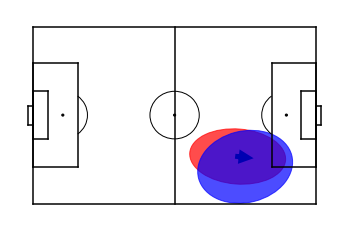

0.006641650623836523 188 201
pass11_opp (red) -> receival5_opp (blue)


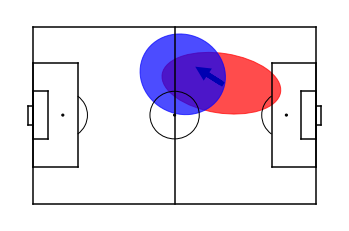

0.006524553380452912 35 48
pass8 (red) -> receival2 (blue)


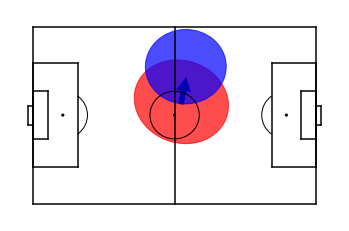

0.006399633782195139 38 51
pass11 (red) -> receival5 (blue)


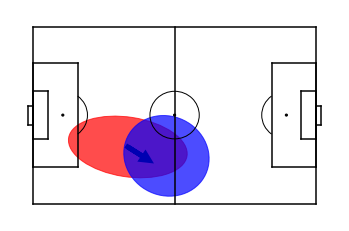

0.006378669137741659 178 202
pass1_opp (red) -> receival6_opp (blue)


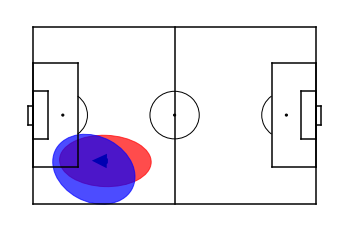

0.006351253370070112 180 199
pass3_opp (red) -> receival3_opp (blue)


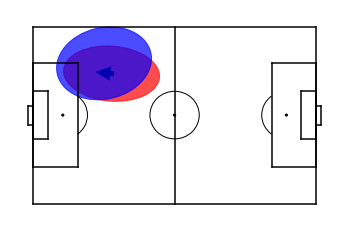

0.006196095569138215 51 64
receival5 (red) -> dribble2 (blue)


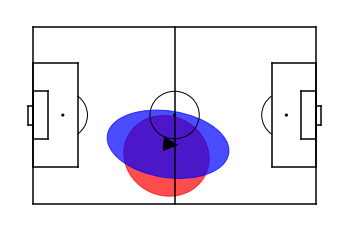

0.006148320745323112 201 214
receival5_opp (red) -> dribble2_opp (blue)


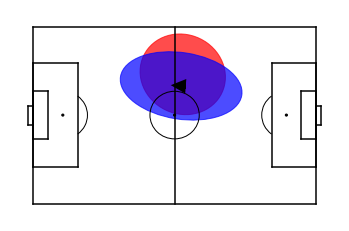

0.006022054962377374 37 48
pass10 (red) -> receival2 (blue)


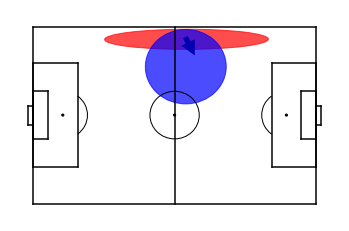

In [230]:
probs = []
for i in range(len(trans)):
    for j in range(len(trans)):
        probs.append((trans[i,j],i,j))
probs = sorted(probs,reverse=True)
movs = [(p,i,j) for p,i,j in probs]# if i != j]

cols = list(ucprobas.columns)

def test(i,j):
    return True
    return "goal1" in cols[j]# and "opp" not in cols[j]
    return "shot" in cols[i] and "opp" not in cols[j]

interestmovs = [(p,i,j) for p,i,j in movs 
                if test(i,j)
                #"pass" not in cols[i]
                   # and "receival" not in cols[i]
                   # and "dribble" not in cols[i]
               ]

for p,i,j in interestmovs[:10]:
    print(p,i,j)
    print(cols[i],"(red)","->",cols[j],"(blue)")
    ax = mps.field(show=False)
    ty,k = gmme._global_to_local(i % gmme.total_components())
    is_opp = i > gmme.total_components() - 1
    vis.plot_component_w_arrow(gmme.models[ty],k,ax=ax,color="red",mirror=is_opp,show=False)
    ty,k = gmme._global_to_local(j % gmme.total_components())
    is_opp = j > gmme.total_components() - 1
    vis.plot_component_w_arrow(gmme.models[ty],k,ax=ax,color="blue",mirror=is_opp,show=False)
    plt.show()

In [ ]:
labels = np.argmax(probas.values,axis=1)

for p,i,j in movs[:10000]:
    cols = gmme._columns()
    if "shot" in cols[j] and "kick" not in cols[j]:# or True:
        print(p,i,j)
        print(cols[i],"(blue)","->",cols[j],"(red)")
        l_idx = (labels == i) | (labels == j)
        twocolors = ["blue" if l == i else "red" for l in labels[l_idx]]
        axs = vis.locmovaxes()
        axs[0].scatter(a.x[l_idx],a.y[l_idx],color=twocolors)
        axs[1].scatter(a.dx[l_idx],a.dy[l_idx],color=twocolors)
        plt.show()
    if p < 50:
        break

In [ ]:
labels = np.argmax(probas.values,axis=1)

for p,i,j in movs[:10000]:
    cols = gmme._columns()
    if "shot" in cols[j] and "kick" not in cols[j]:# or True:
        print(p,i,j)
        print(cols[i],"(blue)","->",cols[j],"(red)")
        l_idx = (labels == i) | (labels == j)
        twocolors = ["blue" if l == i else "red" for l in labels[l_idx]]
        axs = vis.locmovaxes()
        axs[0].scatter(a.x[l_idx],a.y[l_idx],color=twocolors)
        axs[1].scatter(a.dx[l_idx],a.dy[l_idx],color=twocolors)
        plt.show()
    if p < 5:
        break